<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/feature_generation/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [3]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/train.csv'

In [4]:
df_source = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')

In [5]:
df_source.shape, df_submission.shape

((22730, 17), (15154, 16))

# NAN check

In [ ]:
from sklearn_utils import nan_report

_ = nan_report(df_source, 0.0)

0 / 17 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


In [ ]:
_ = nan_report(df_submission, 0.0)

0 / 16 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


# INF check

In [ ]:
from sklearn_utils import inf_report

_ = inf_report(df_source, 0.0)
_ = inf_report(df_submission, 0.0)

No infinite values observed
No infinite values observed


# Check outliers before splitting the data

## Visualize outliers

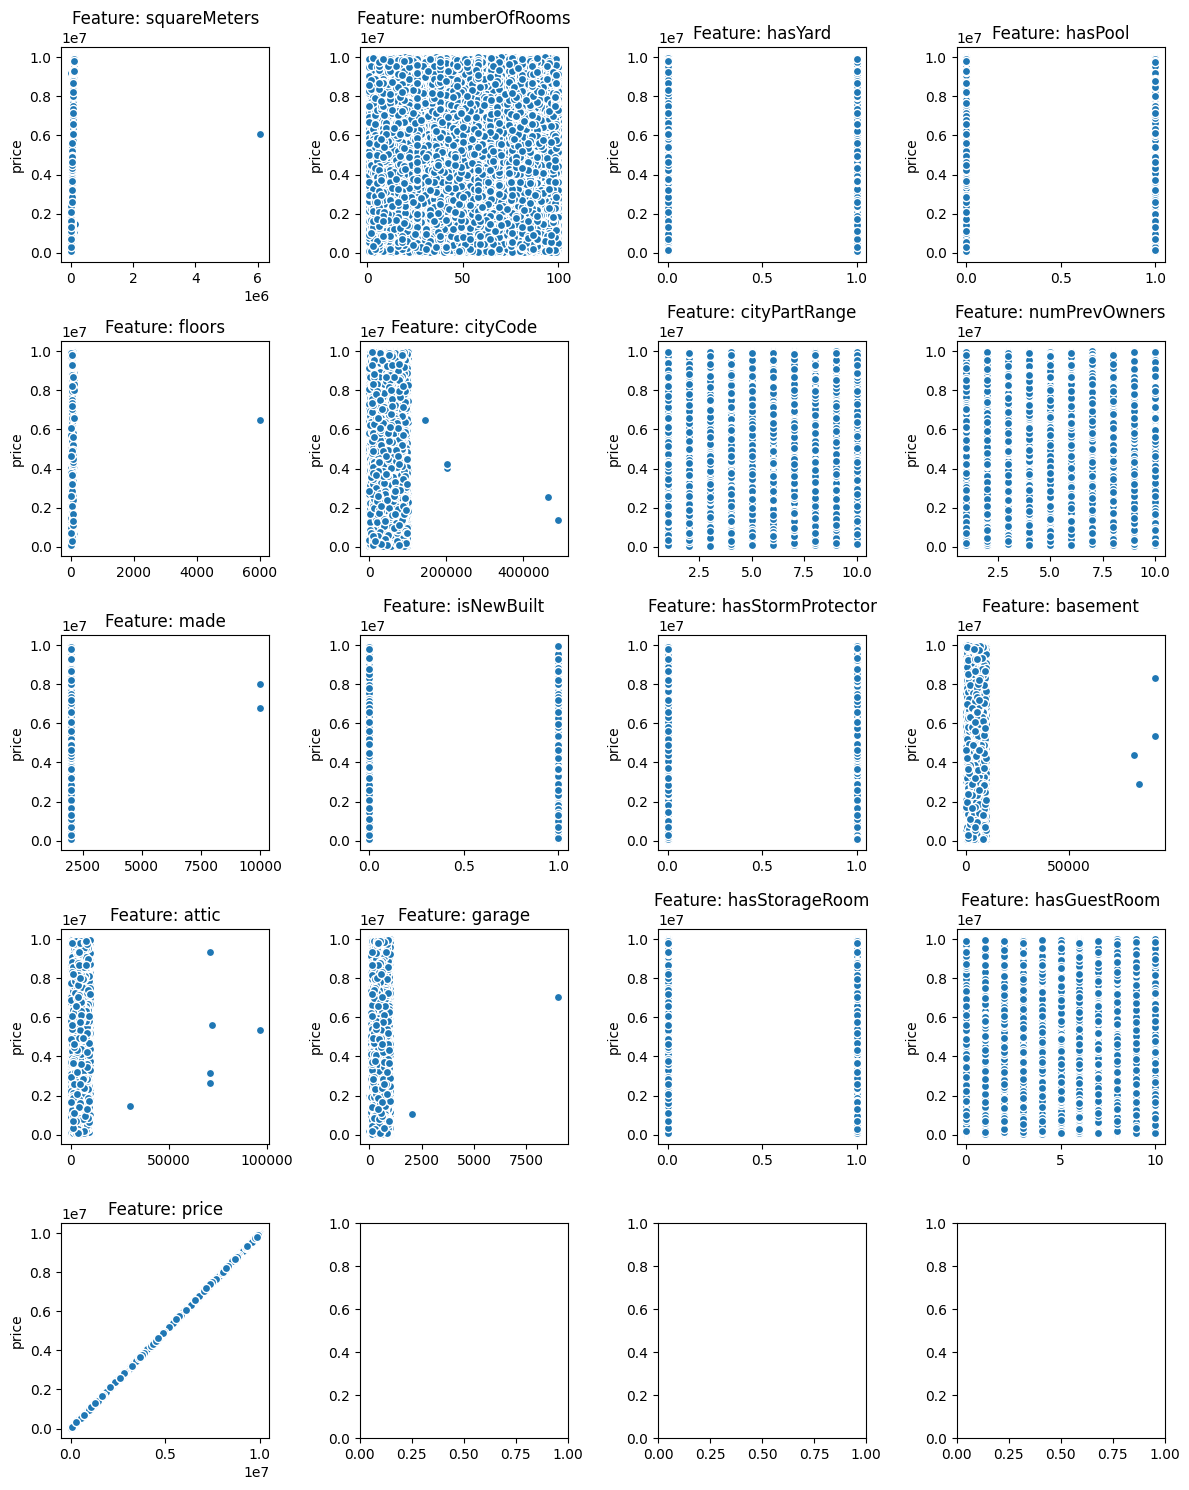

In [6]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## IQR cleaning

In [7]:
def plot_quantile_outliers(df, column_quantile_dict, n_cols=5):
    temp = len(column_quantile_dict.keys()) // n_cols
    n_rows = temp if len(column_quantile_dict.keys()) % n_cols == 0 else temp + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = ax.flatten()
    counter = 0
    outlier_indices = list()
    for column_name, quantile in column_quantile_dict.items():

        subset = df.loc[
            df[column_name] > df_source[column_name].quantile(quantile)
        ]
        print(f'For {column_name}: {subset.shape[0]} outliers')
        print(f'Indices: {list(subset.index)}')

        outlier_indices += list(subset.index)

        ax[counter].scatter(df_source[column_name], df_source['price'])
        ax[counter].scatter(subset[column_name], subset['price'])
        ax[counter].set_ylabel('price')
        ax[counter].set_xlabel(column_name)

        counter += 1
    return set(outlier_indices)

For squareMeters: 20 outliers
Indices: [648, 2323, 3184, 3515, 4657, 4741, 5261, 8054, 8533, 10043, 13686, 14864, 15334, 15749, 17330, 17742, 19081, 19438, 19978, 21320]
For floors: 1 outliers
Indices: [5659]
For cityCode: 7 outliers
Indices: [299, 1326, 2425, 10987, 20576, 20735, 22631]
For made: 5 outliers
Indices: [2113, 3608, 19124, 19748, 21400]
For basement: 4 outliers
Indices: [2107, 3995, 15068, 18926]
For attic: 7 outliers
Indices: [3828, 4909, 12858, 13633, 13642, 17168, 19994]
For garage: 2 outliers
Indices: [14878, 17629]


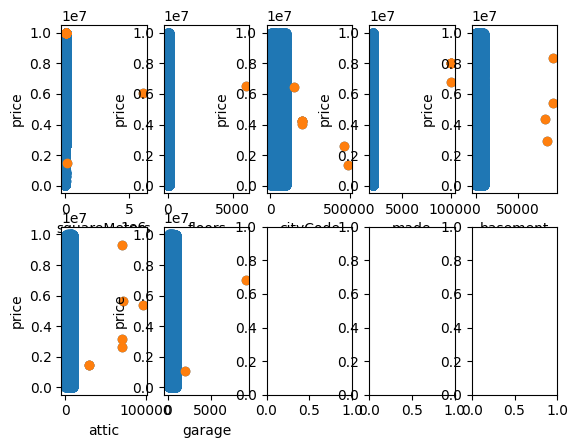

In [8]:
outlier_indices = plot_quantile_outliers(
    df_source,
    {
        'squareMeters': 0.999,
        'floors': 0.999,
        'cityCode': 0.9997,
        'made': 0.999,
        'basement': 0.9995,
        'attic': 0.9995,
        'garage': 0.999
    }
)

In [9]:
len(outlier_indices) / df_source.shape[0]

0.002023757149142103

In [10]:
print(f'Data size before IQR cleaning: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_indices), :]
print(f'Data size after IQR cleaning: {df_source.shape}')

Data size before IQR cleaning: (22730, 17)
Data size after IQR cleaning: (22684, 17)


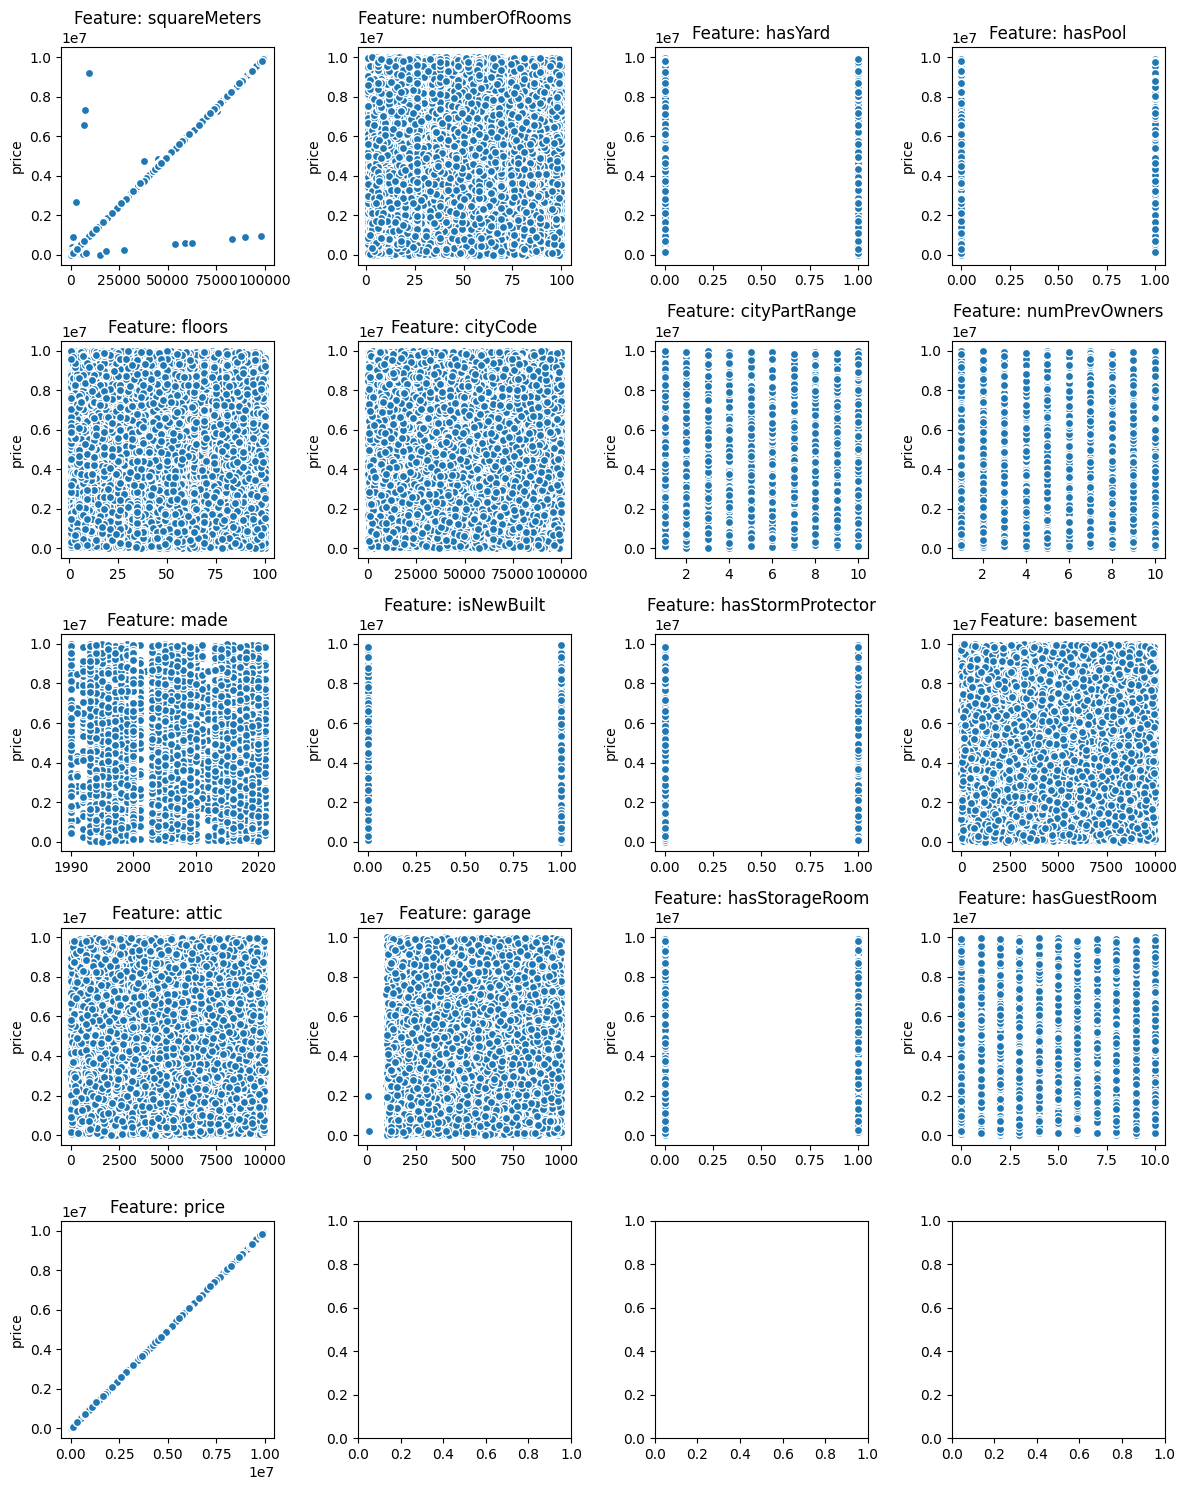

In [11]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## Local outlier factor cleaning

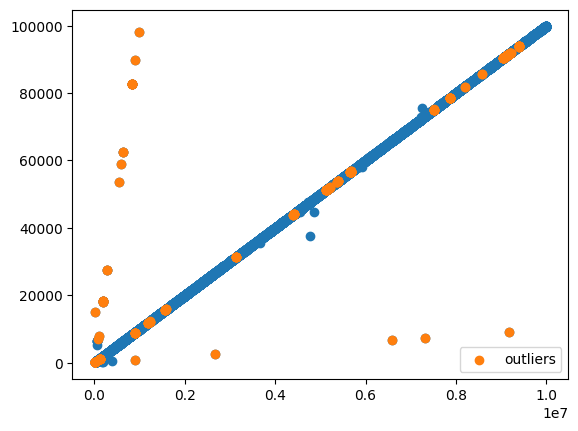

In [12]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=60)
preds = clf.fit_predict(df_source[['price', 'squareMeters']])

outlier_indices = np.where(preds == -1)[0]
outlier_subset = df_source.iloc[outlier_indices]

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])
ax.scatter(outlier_subset['price'], outlier_subset['squareMeters'], label='outliers')
ax.legend()

We will clean (244,) outliers
shape before: (22684, 17)
shape after: (22440, 17)
(22440, 17)


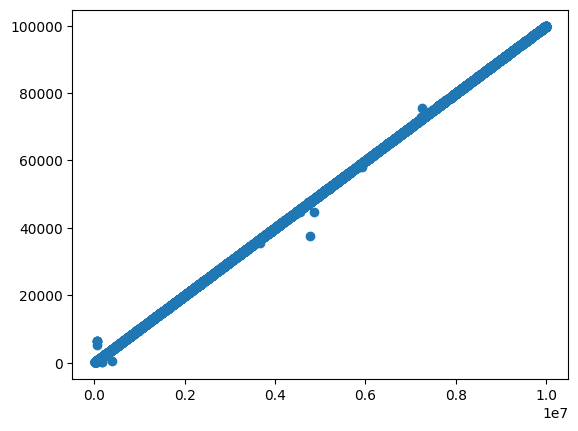

In [13]:
print(f'We will clean {outlier_indices.shape} outliers')

print(f'shape before: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_subset.index), :]
print(f'shape after: {df_source.shape}')

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])

print(df_source.shape)

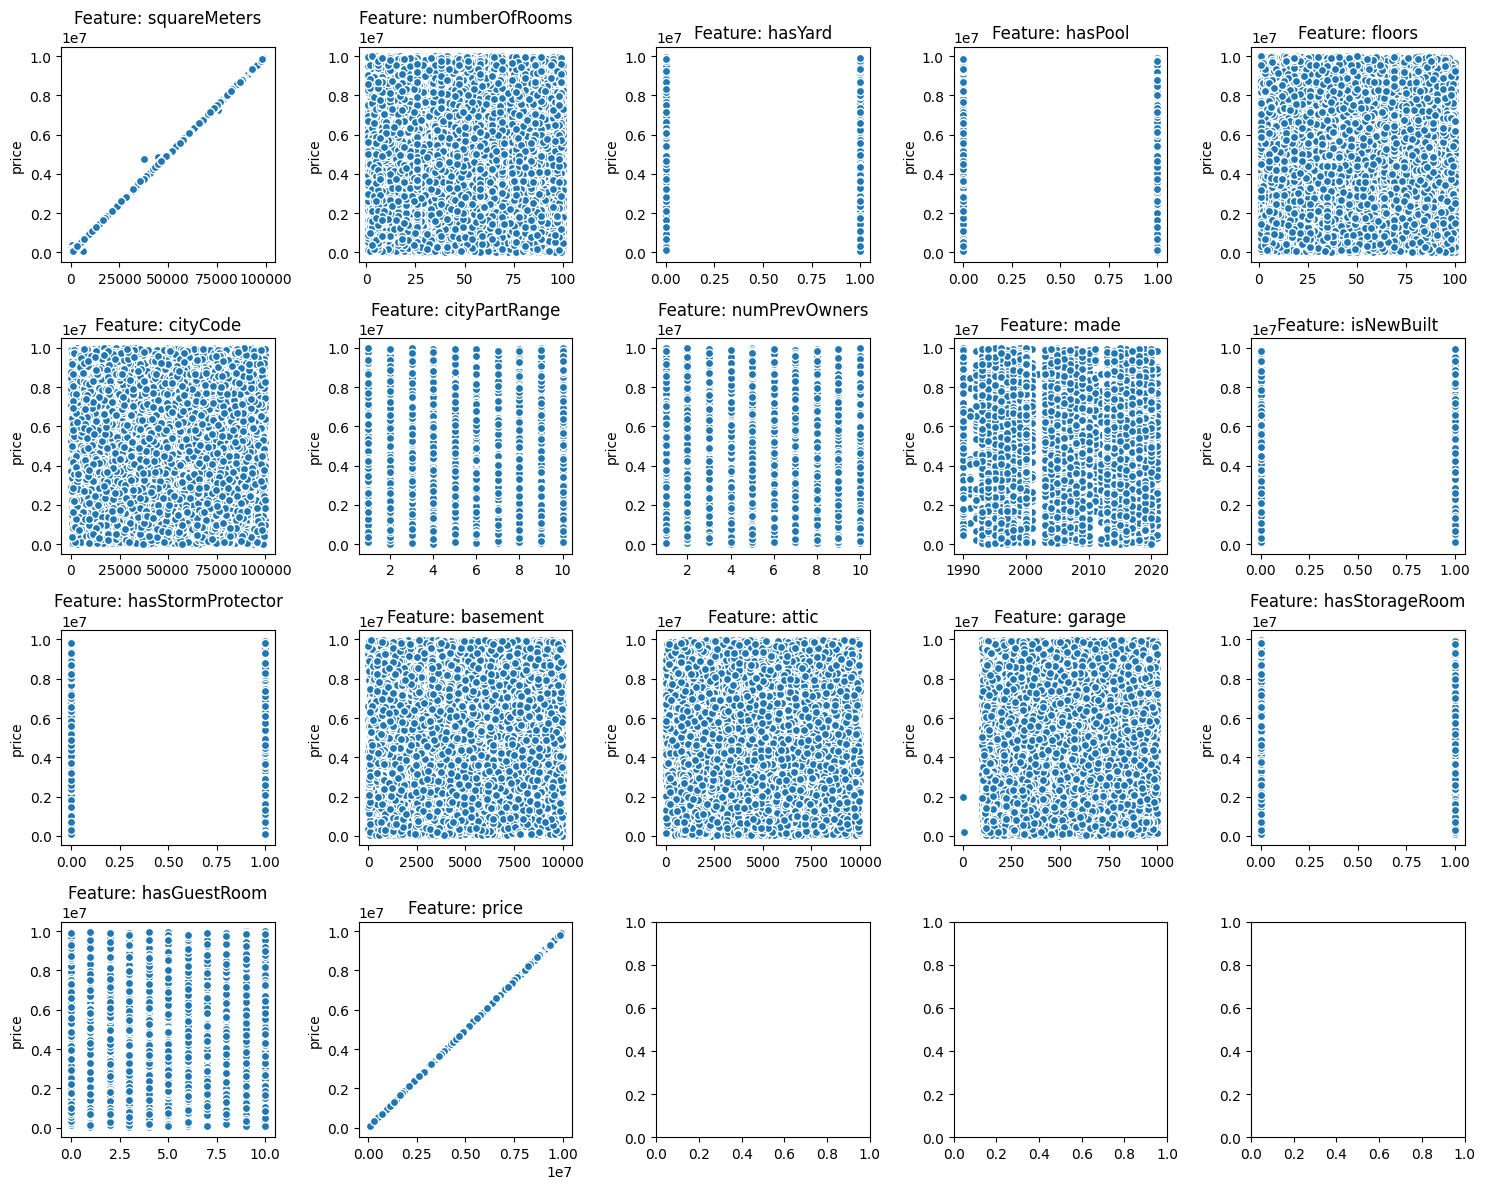

In [14]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=5,
    height_scale=3.0
)

# Split the data

In [15]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
EXPLORATION_SIZE = 0.5
RANDOM_STATE = 42

In [16]:
from sklearn.model_selection import train_test_split

df_trainval, df_test = train_test_split(
    df_source,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

df_trainval.shape, df_test.shape

((17952, 17), (4488, 17))

In [17]:
df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

df_train.shape, df_val.shape

((14361, 17), (3591, 17))

In [18]:
df_exploration, _ = train_test_split(
    df_train,
    train_size=EXPLORATION_SIZE,
    random_state=RANDOM_STATE
)

df_exploration.shape

(7180, 17)

In [19]:
def X_Y(df, return_y=True):

    X = df.loc[:, df.columns != 'price']
    if return_y:
        Y = df['price']
        return X, Y
    else:
        return X, None

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)

## Check target distribution

Visualizing datasets distributions
(1, 1) <class 'numpy.ndarray'>


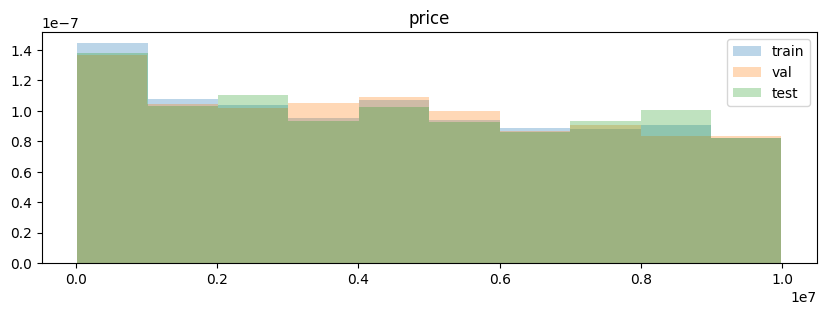

In [20]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'train': df_train,
        'val': df_val,
        'test': df_test,
    },
    ['price'],
    grid_width=1
)

# Data exploration (from now on - on train df only)

## Overall

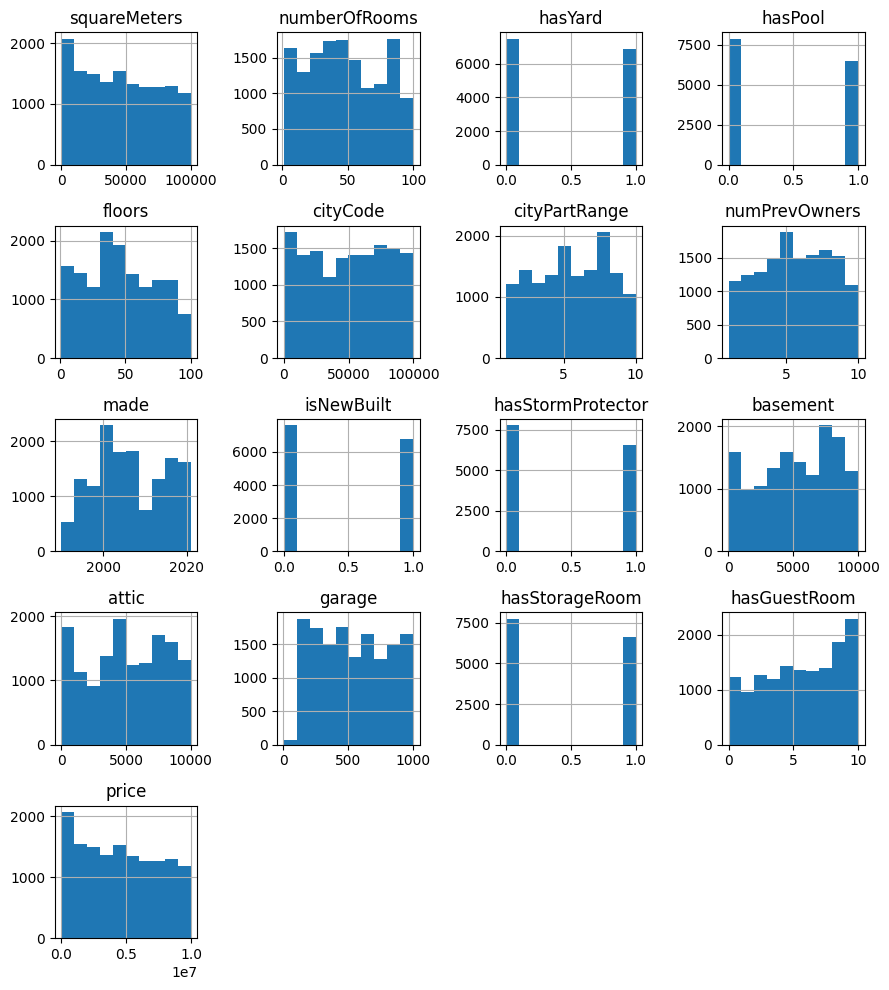

In [ ]:
_ = df_train.hist(figsize=(9, 10))
plt.tight_layout()

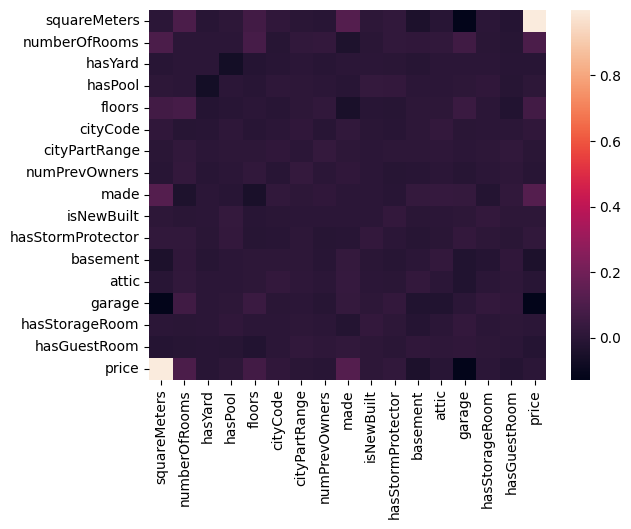

In [ ]:
from sklearn_utils import plot_correlation_matrix


_ = plot_correlation_matrix(df_train, delete_diagonals=True)

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

## squareMeters

<Axes: >

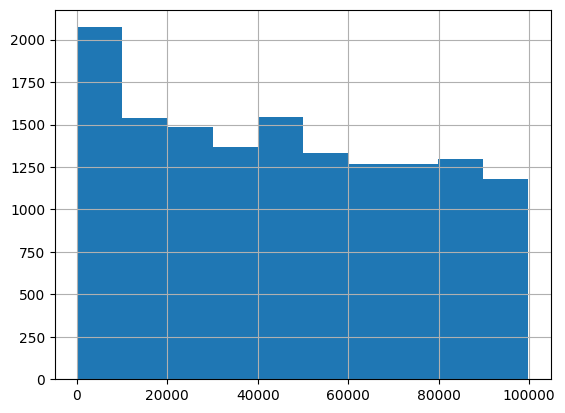

In [ ]:
df_train['squareMeters'].hist()

In [ ]:
df_train['squareMeters'].describe()

count    14361.000000
mean     46053.414734
std      29209.389570
min        137.000000
25%      19857.000000
50%      44111.000000
75%      71061.000000
max      99820.000000
Name: squareMeters, dtype: float64

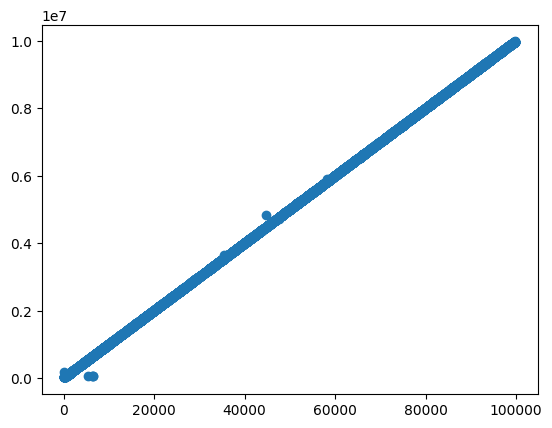

In [ ]:
plt.scatter(
    df_train['squareMeters'],
    df_train['price'],
)

(9, 17)


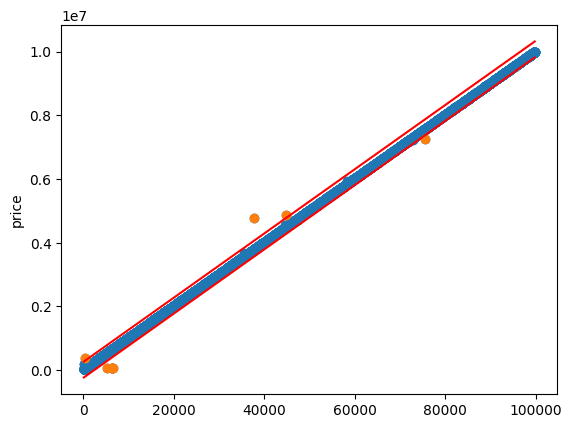

In [ ]:
_, ax = plt.subplots()
ax.scatter(
    y=df_source['price'],
    x=df_source['squareMeters']
)
ax.set_ylabel('price')

COEF = 100.83
x = np.linspace(df_source['squareMeters'].min(), df_source['squareMeters'].max(), 100)
y = np.array([COEF * x_ for x_ in x])
OFFSET = 250000
ax.plot(x, y + OFFSET, color='red')
ax.plot(x, y - OFFSET, color='red')

outlier_subset = df_source.loc[
    (df_source['price'] > df_source['squareMeters'] * COEF + OFFSET) |
    (df_source['price'] < df_source['squareMeters'] * COEF - OFFSET)
]
print(outlier_subset.shape)
ax.scatter(outlier_subset['squareMeters'], outlier_subset['price'])

In [ ]:
outlier_subset.head(10)

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
986            6348             74        1        0      54     55403   
6971           6397             80        1        0      84     46757   
9316          75486             78        1        1      84     42527   
9663            380             86        1        1      81     96283   
12685          5277             87        0        0      26     76242   
13156         37647             50        0        0      38      5644   
13365          6396             86        1        0      31     31987   
14589         44731             87        0        0      77     63006   
15653          6453             41        0        1      52     57460   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
986                4              7  2000           0                  1   
6971               8              6  2020           0                  0   
9316               9             10  2000           1                  0   
9663              10              7  2000           1                  0   
12685              5              9  2000           1                  1   
13156              5              4  2015           1                  1   
13365              6              5  2000           0                  0   
14589              5              6  2013           0                  0   
15653              4              7  2020           0                  1   

       basement  attic  garage  hasStorageRoom  hasGuestRoom      price  
id                                                                       
986        4245   7997     797               0             3    65465.1  
6971       7174   7486     746               0             5    65465.1  
9316       7325   3753     308               0            10  7254308.1  
9663       5131   7793     411               0             8   383898.1  
12685      8687    786     218               0             9    53940.1  
13156       985    989     574               0             3  4773675.5  
13365      5645   3491     602               1            10    65465.1  
14589      5379    889     313               1             6  4852762.3  
15653       759   6838     186               0             4    65465.1

## NumberOfRooms

<Axes: >

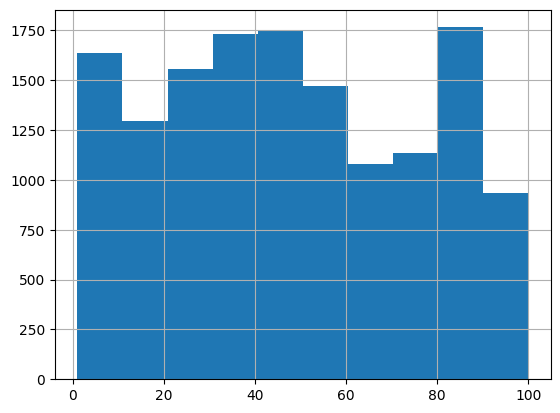

In [ ]:
df_train['numberOfRooms'].hist()

<Axes: xlabel='numberOfRooms', ylabel='price'>

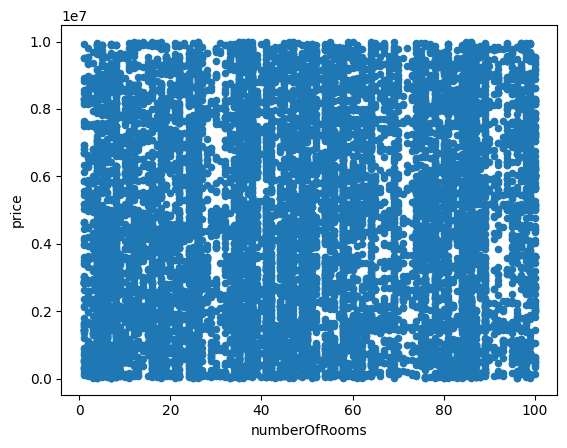

In [ ]:
df_train.plot.scatter('numberOfRooms', 'price')

In [ ]:
df_train[['price', 'numberOfRooms']].corr()

price  numberOfRooms
price          1.000000       0.095754
numberOfRooms  0.095754       1.000000

## hasYard

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

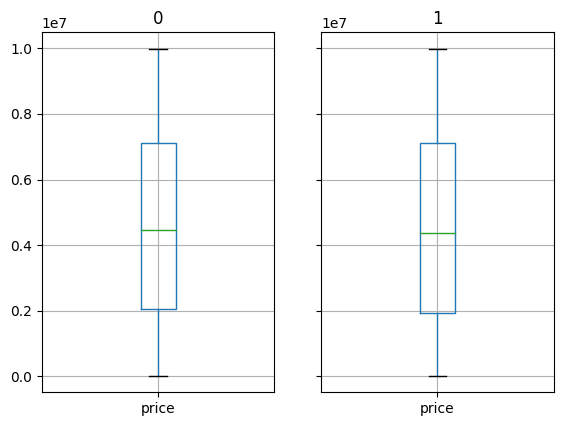

In [ ]:
df_train.groupby('hasYard')[['price']].boxplot()

<Axes: xlabel='hasYard'>

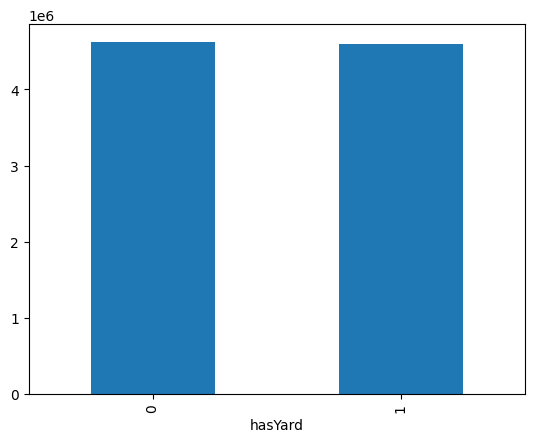

In [ ]:
df_train.groupby('hasYard')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

## hasPool

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

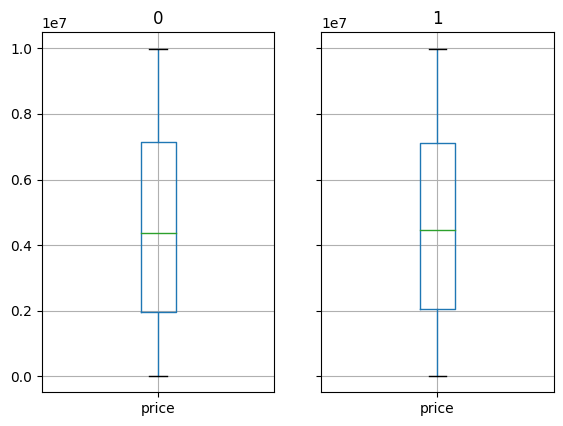

In [ ]:
df_train.groupby('hasPool')[['price']].boxplot()

<Axes: xlabel='hasPool'>

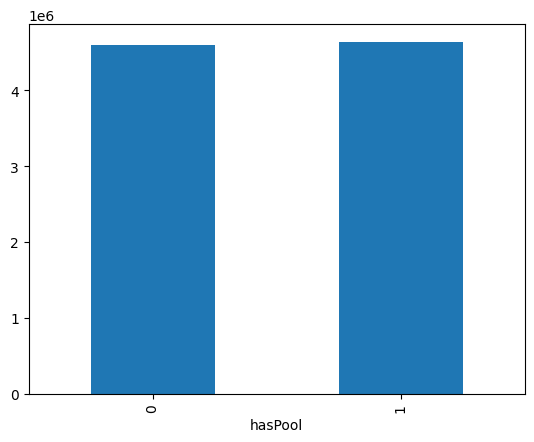

In [ ]:
df_train.groupby('hasPool')['price'].aggregate('mean').plot(kind='bar')

## floors

<Axes: >

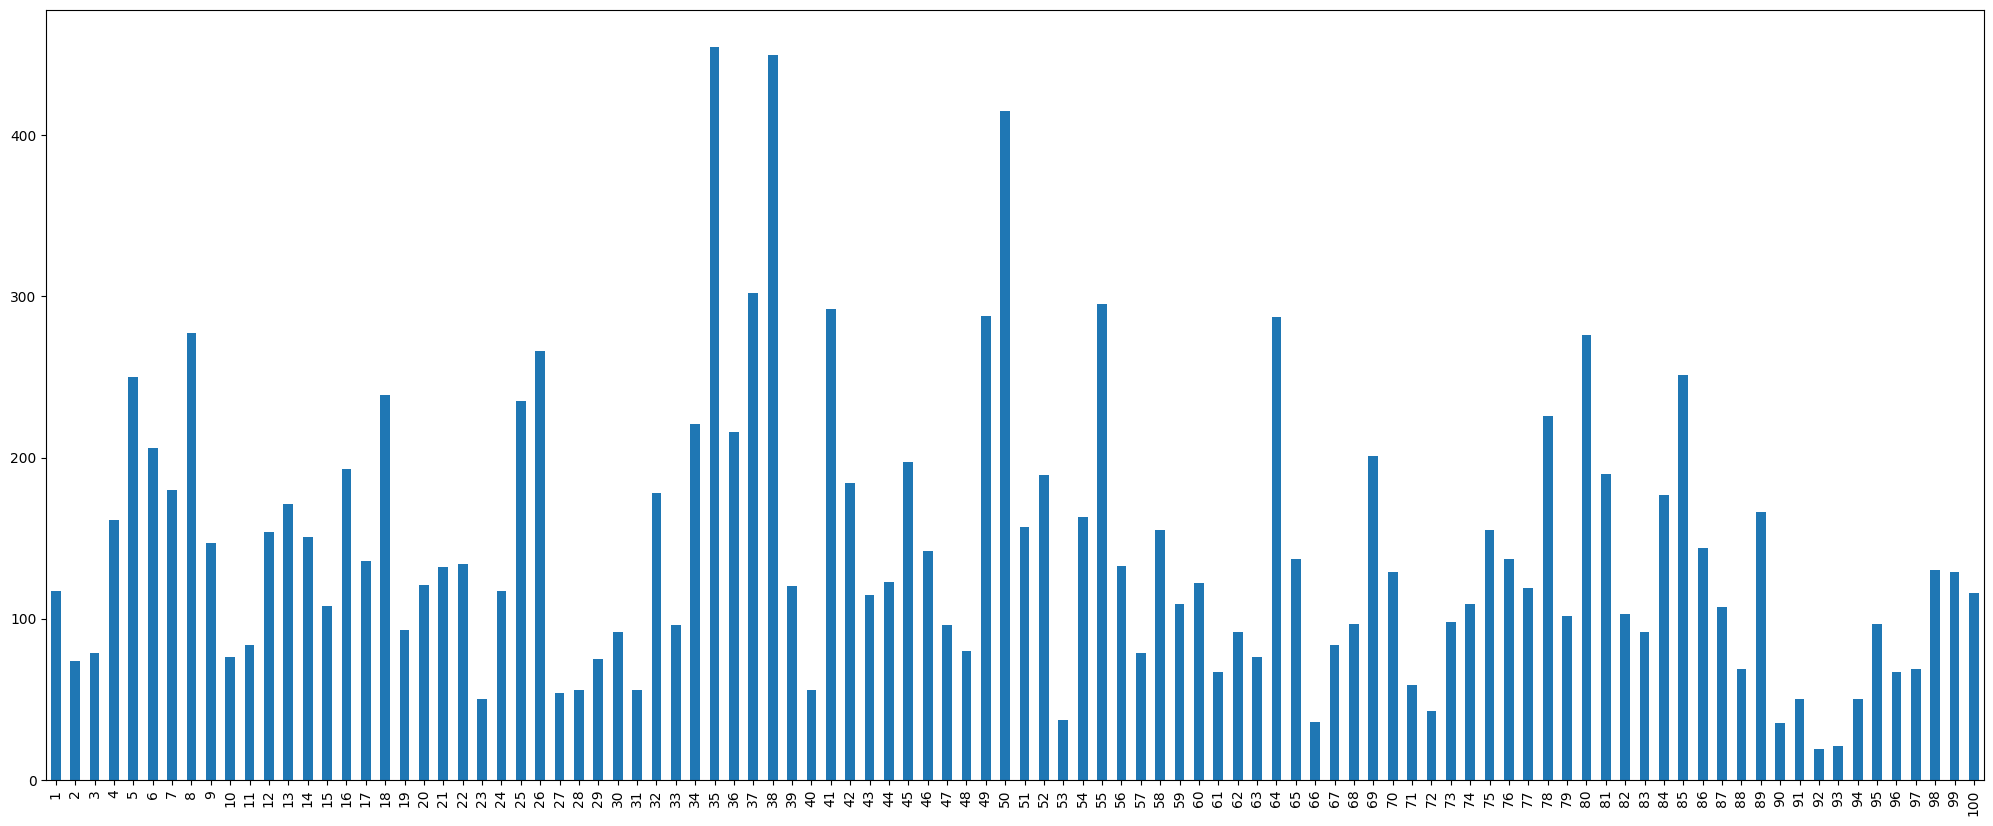

In [ ]:
df_train.floors \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', figsize=(25, 10))

<Axes: xlabel='floors'>

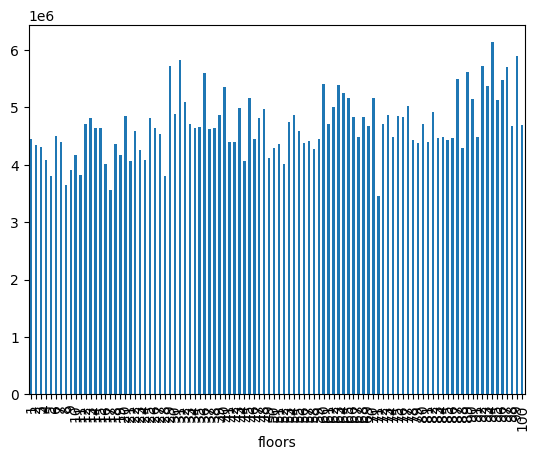

In [ ]:
df_train \
    .groupby('floors')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

<Axes: xlabel='floors', ylabel='price'>

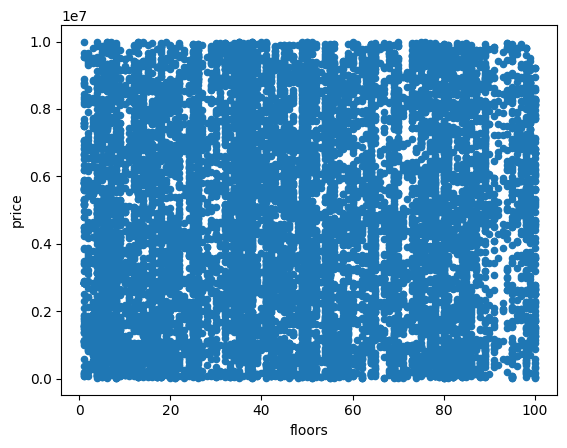

In [ ]:
df_train.plot.scatter(x='floors', y='price')

<Axes: xlabel='floors_binned'>

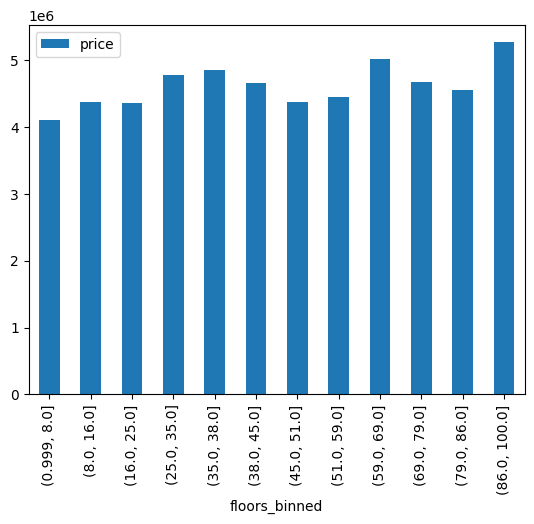

In [ ]:
df_train['floors_binned'] = pd.qcut(
    df_train['floors'],
    q=np.linspace(0.0, 1.0, num=13, endpoint=True)
)

df_train \
    .groupby('floors_binned')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'boxesChecked', 'floors_binned'],
      dtype='object')

## cityCode

<Axes: >

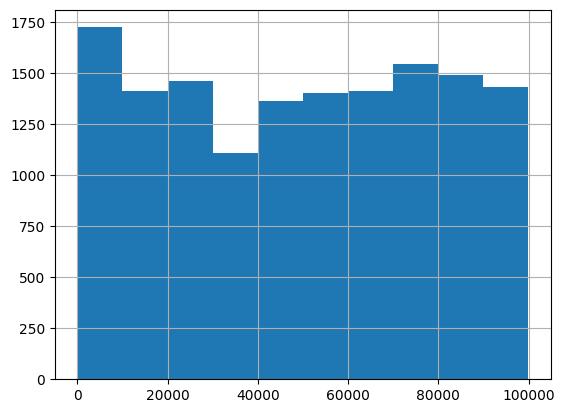

In [ ]:
df_train.cityCode.hist()

<Axes: xlabel='cityCodeBinned'>

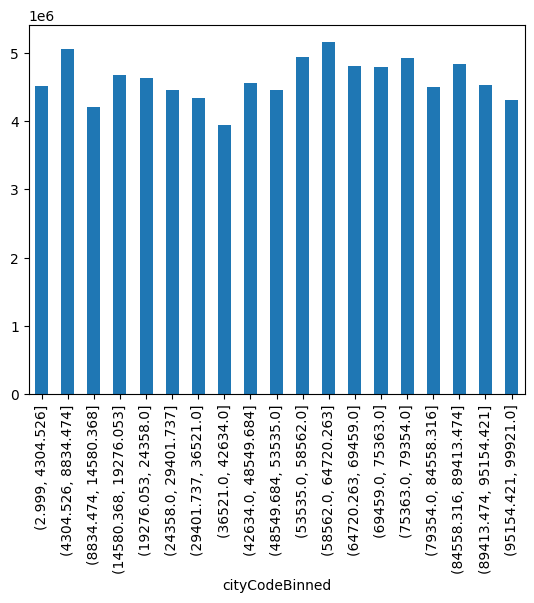

In [ ]:
df_train['cityCodeBinned'] = pd.qcut(df_train['cityCode'], np.linspace(0.0, 1.0, num=20))
df_train \
    .groupby('cityCodeBinned')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train.cityCodeBinned.value_counts().sum(), df_train.shape[0]

(14361, 14361)

## cityPartRange

<Axes: >

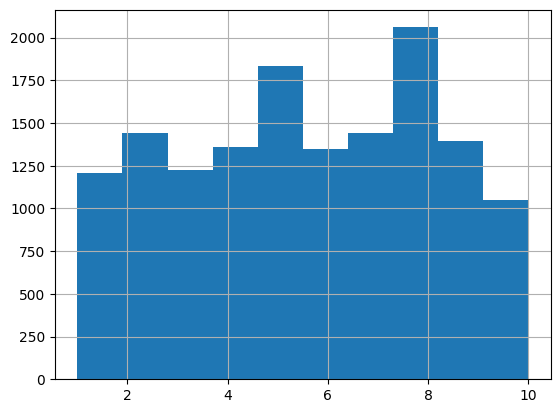

In [ ]:
df_train['cityPartRange'].hist()

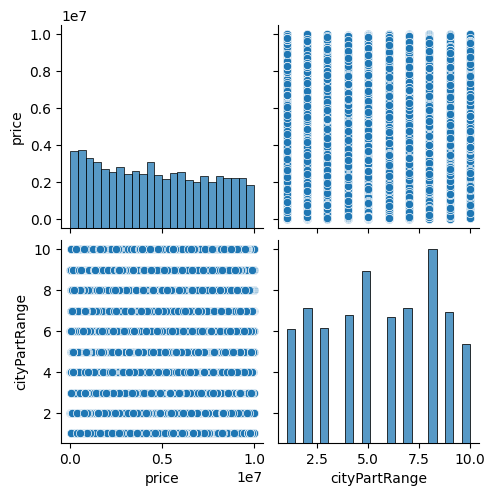

In [ ]:
sns.pairplot(df_train[['price', 'cityPartRange']])

In [ ]:
df_train.cityPartRange.unique()

array([ 4,  3,  7,  1,  5, 10,  6,  8,  9,  2])

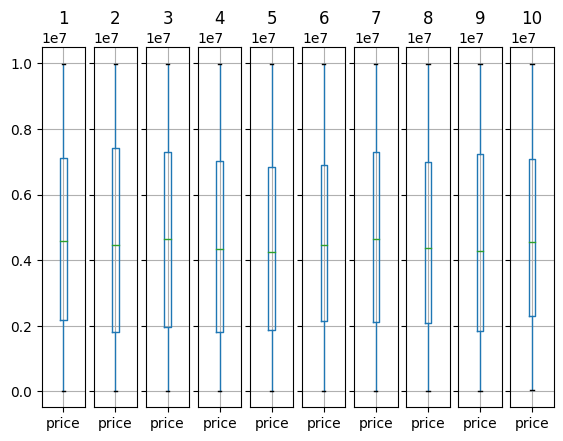

In [ ]:
_ = df_train \
    .groupby('cityPartRange')[['price']] \
    .boxplot(sharex=False, layout=(1, 10))

<Axes: xlabel='cityPartRangeBinned,cityCodeBinned'>

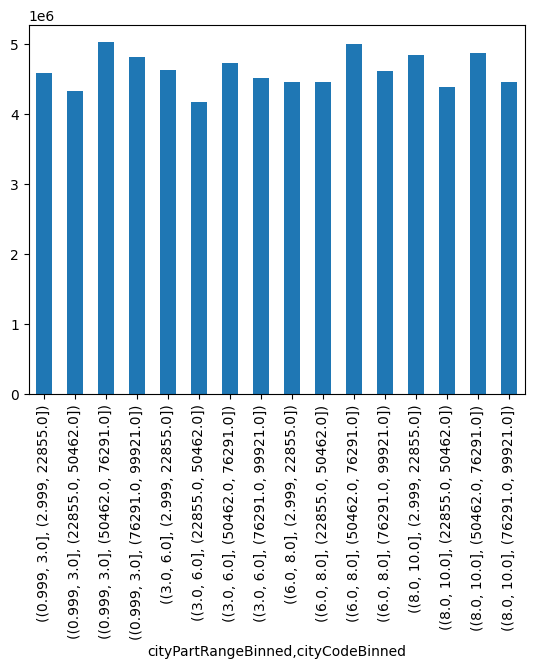

In [ ]:
df_train['cityPartRangeBinned'] = pd.qcut(
    df_train['cityPartRange'],
    np.linspace(0.0, 1.0, num=5, endpoint=True)
)

df_train.groupby(['cityPartRangeBinned', 'cityCodeBinned'])['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

<Axes: >

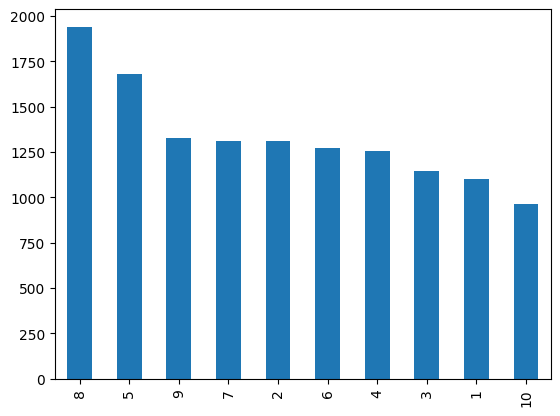

In [ ]:
df_train.cityPartRange.value_counts().plot(kind='bar')

<Axes: xlabel='cityPartRange'>

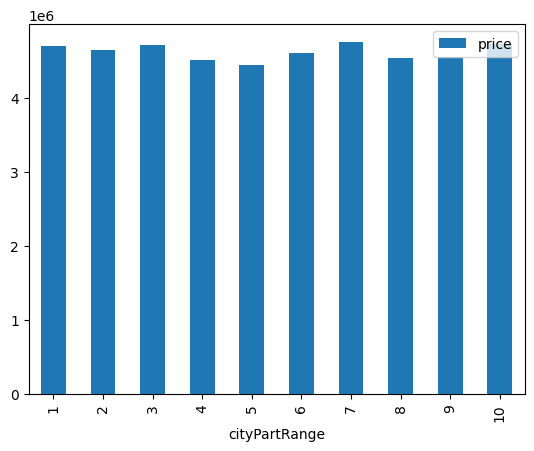

In [ ]:
df_train.groupby('cityPartRange')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned'],
      dtype='object')

## numPrevOwners

<Axes: >

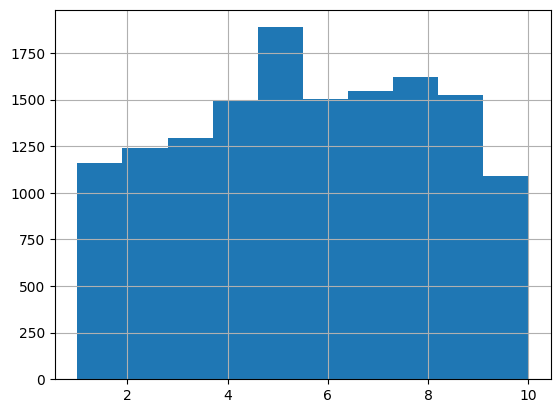

In [ ]:
df_train.numPrevOwners.hist()

<Axes: >

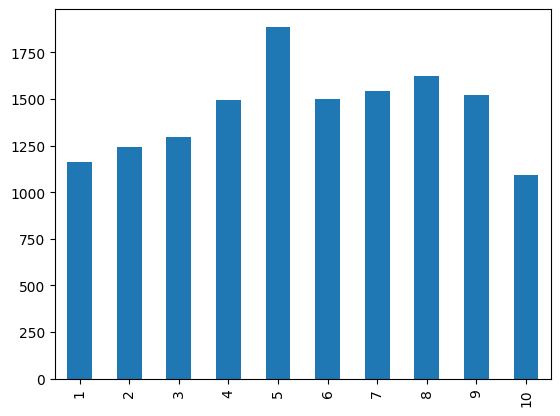

In [ ]:
df_train.numPrevOwners \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar')

<Axes: xlabel='numPrevOwners'>

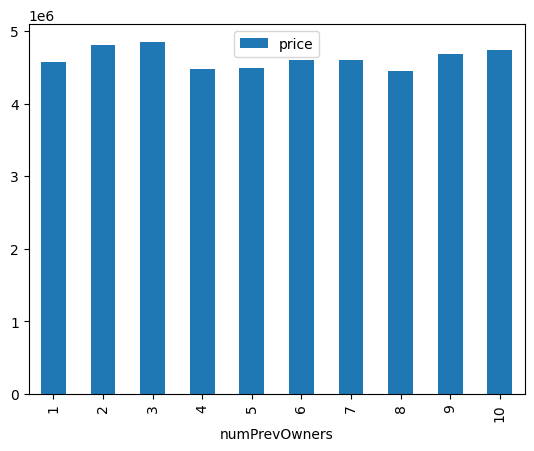

In [ ]:
df_train \
    .groupby('numPrevOwners')[['price']] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned'],
      dtype='object')

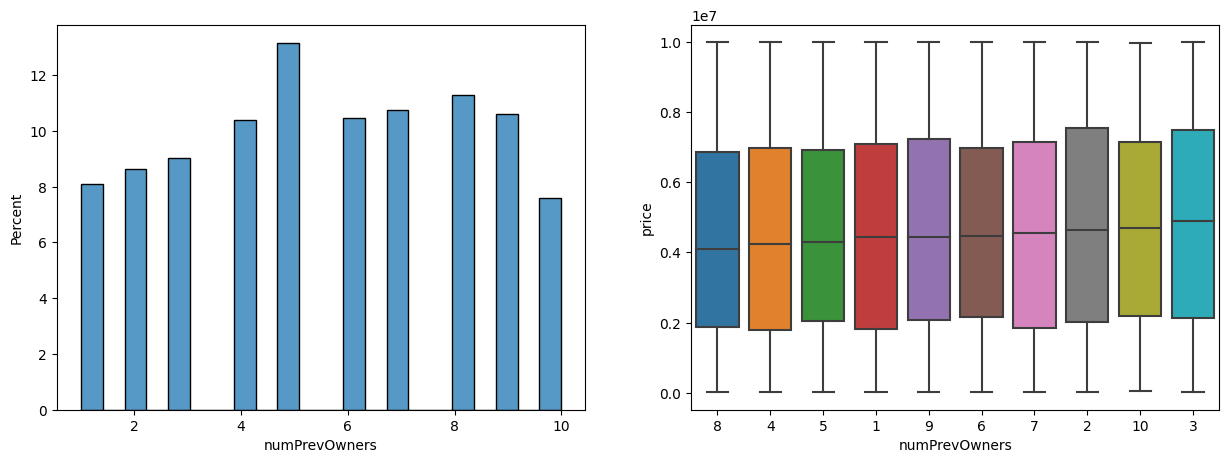

In [ ]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'numPrevOwners', 'price')

## made

<Axes: >

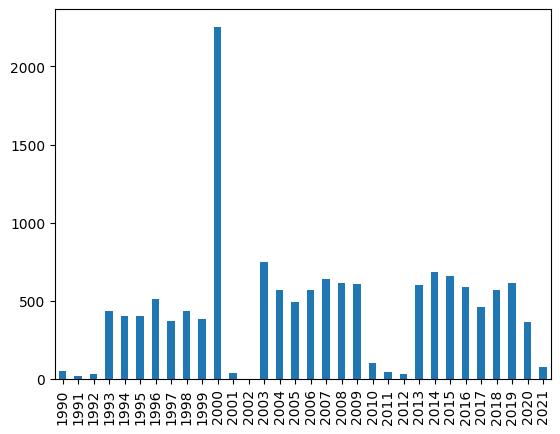

In [ ]:
df_train['made'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='made'>

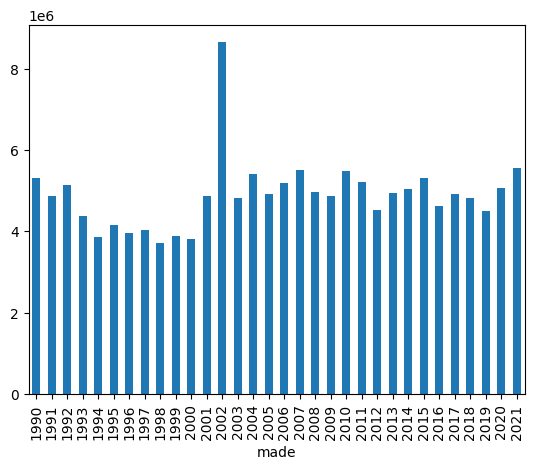

In [ ]:
df_train.groupby('made')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

In [ ]:
df_train[df_train['made'] == 2002]

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                      
8337         86383             95        0        0       8     98660   

      cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                        
8337              3             10  2002           1                  1   

      basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
id                                                                       
8337      4118   4349     877               1             7  8648031.0   

          cityCodeBinned cityPartRangeBinned  
id                                            
8337  (76291.0, 99921.0]        (0.999, 3.0]

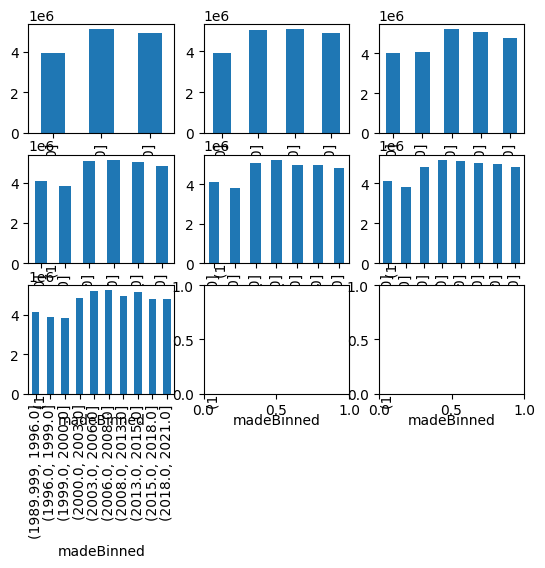

In [ ]:
_, ax = plt.subplots(3, 3)
ax = ax.flatten()
i = 0
for n_bins in [4, 5, 6, 7, 8, 9, 11]:
    df_train['madeBinned'] = pd.qcut(
        df_train['made'],
        np.linspace(0.0, 1.0, n_bins, endpoint=True)
    )

    df_train \
        .groupby('madeBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])
    i += 1

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## isNewBuilt

<Axes: >

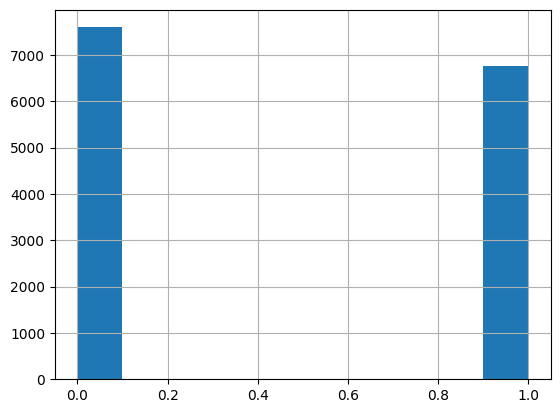

In [ ]:
df_train['isNewBuilt'].hist()

<Axes: xlabel='isNewBuilt'>

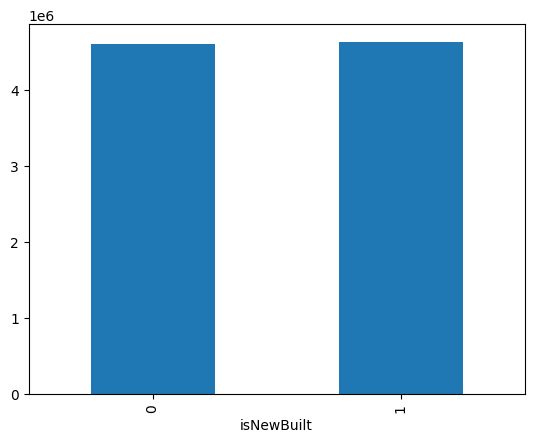

In [ ]:
df_train \
    .groupby('isNewBuilt')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

0         Axes(0.1,0.15;0.363636x0.75)
1    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

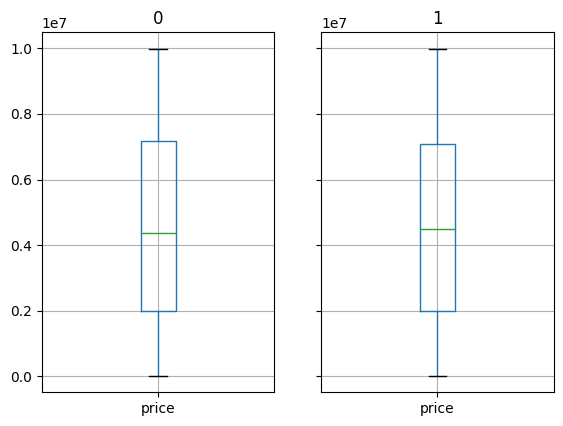

In [ ]:
df_train.groupby('isNewBuilt')[['price']].boxplot()

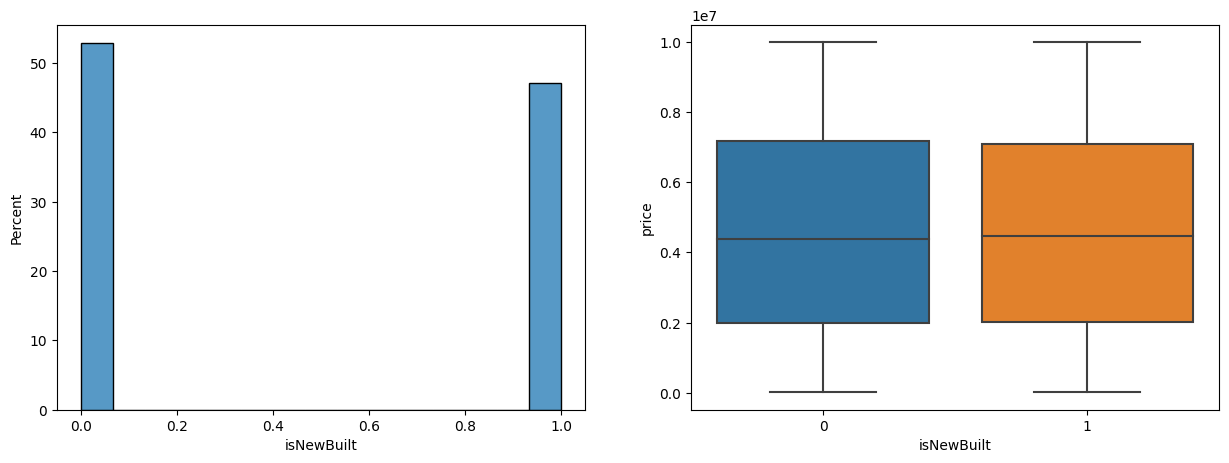

In [ ]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'isNewBuilt', 'price')

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## hasStormProtector

<Axes: >

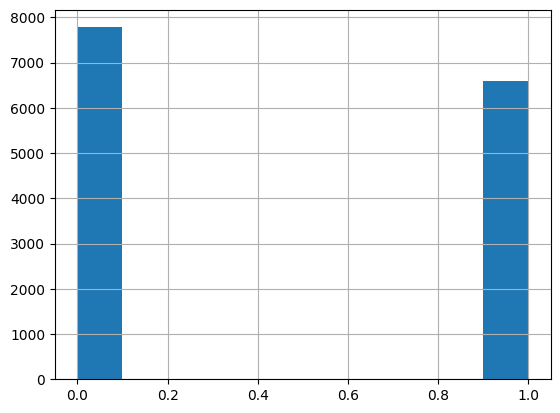

In [ ]:
df_train.hasStormProtector.hist()

<Axes: xlabel='hasStormProtector'>

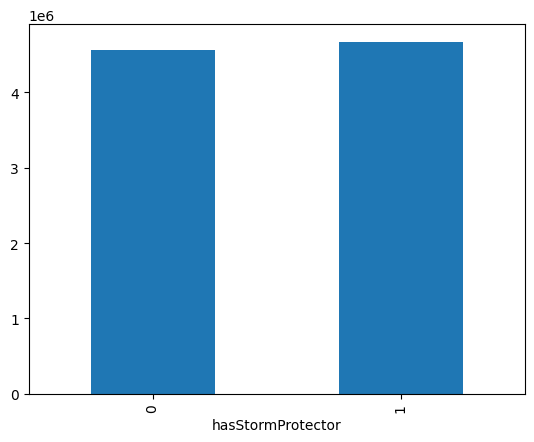

In [ ]:
df_train.groupby('hasStormProtector')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

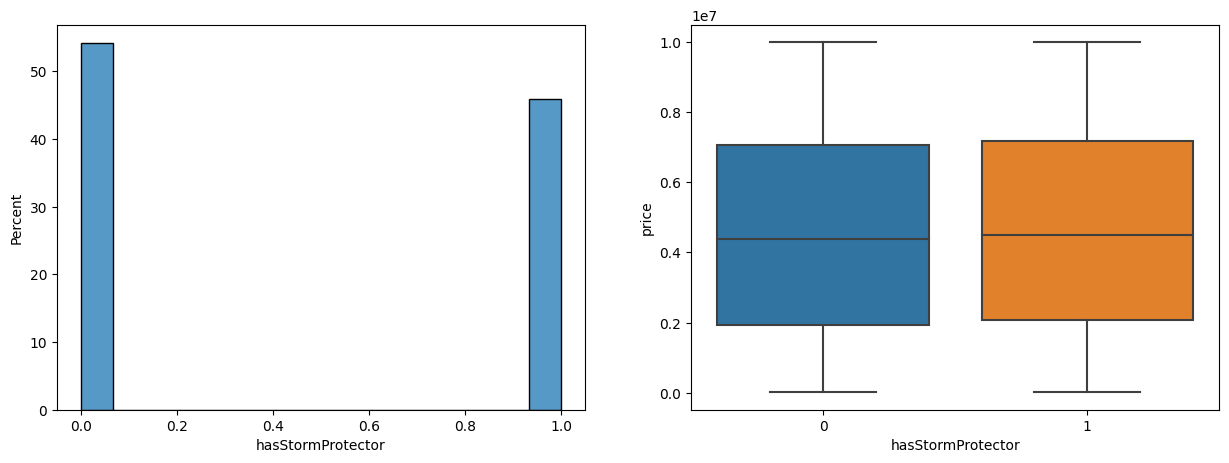

In [ ]:
from sklearn_utils import boxplot_regression

boxplot_regression(
    df_train,
    'hasStormProtector',
    'price'
)

In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'cityCodeBinned', 'cityPartRangeBinned',
       'madeBinned'],
      dtype='object')

## basement

<Axes: >

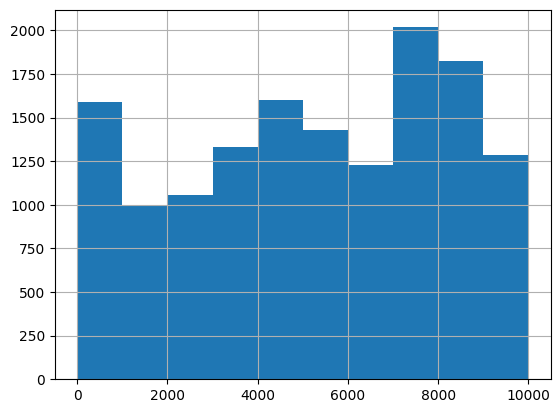

In [ ]:
df_train['basement'].hist()

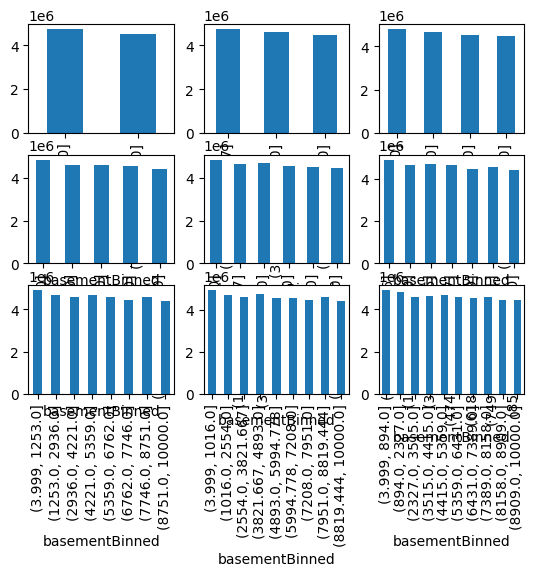

In [ ]:
n_bins = np.arange(3, 12)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['basementBinned'] = pd.qcut(
        df_train['basement'],
        np.linspace(0.0, 1.0, n)
    )

    df_train \
        .groupby('basementBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

## Attic

<Axes: >

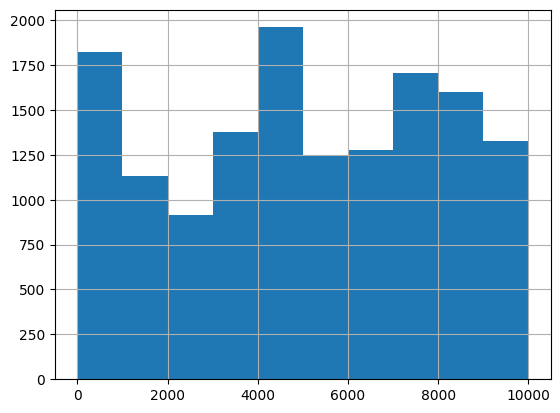

In [ ]:
df_train.attic.hist()

<ipython-input-119-60671cd91597>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


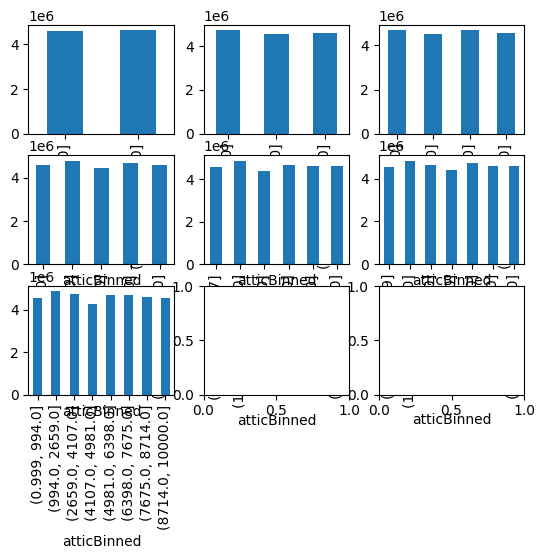

In [ ]:
n_bins = np.arange(3, 10)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['atticBinned'] = pd.qcut(
        df_train['attic'],
        np.linspace(0, 1, n, endpoint=True)
    )

    df_train.groupby('atticBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

plt.tight_layout()

## garage

<Axes: >

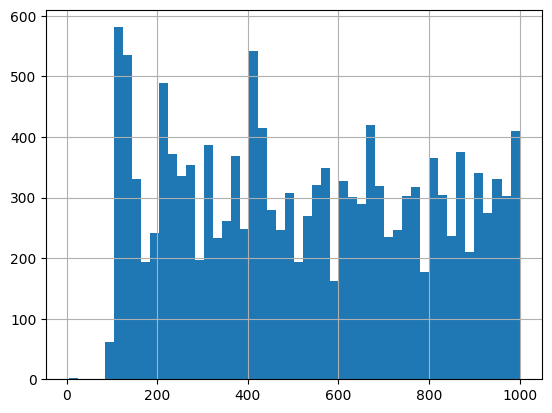

In [ ]:
df_train.garage.hist(bins=50)

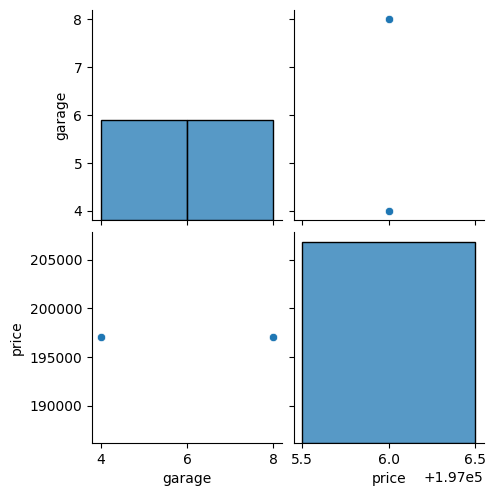

In [ ]:
sns.pairplot(df_train[df_train.garage < 50][['garage', 'price']])

In [ ]:
df_train[df_train['garage'] < 50].head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
3130           1863             82        1        1      81     40618   
11910          1863             41        1        1      80     40631   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
3130               1              4  2000           0                  0   
11910              4              4  2000           0                  0   

       basement  attic  garage  hasStorageRoom  hasGuestRoom     price  \
id                                                                       
3130       7113      8       4               1             1  197006.0   
11910      6283      8       8               1             4  197006.0   

           cityCodeBinned cityPartRangeBinned        madeBinned  \
id                                                                
3130   (22855.0, 50462.0]        (0.999, 3.0]  (1999.0, 2000.0]   
11910  (22855.0, 50462.0]          (3.0, 6.0]  (1999.0, 2000.0]   

         basementBinned     atticBinned  
id                                       
3130   (6431.0, 7389.0]  (0.999, 994.0]  
11910  (5359.0, 6431.0]  (0.999, 994.0]

In [ ]:
df_train[~df_train['garage'] < 70].shape

(14361, 22)

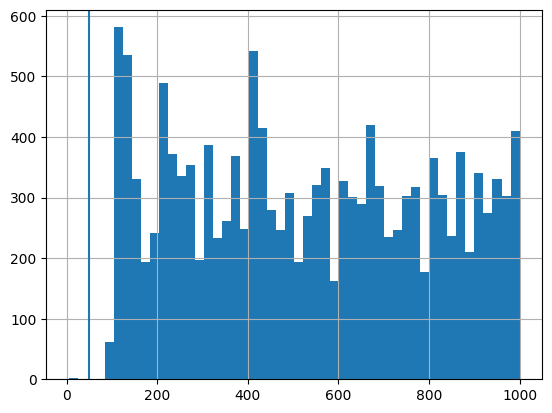

In [ ]:
ax = df_train.garage.hist(bins=50)
ax.axvline(50)

In [ ]:
df_train['price'].duplicated().sum(), df_train.shape

(8121, (14361, 22))

In [ ]:
df_train[df_train['garage'] < 50].head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
3130           1863             82        1        1      81     40618   
11910          1863             41        1        1      80     40631   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
3130               1              4  2000           0                  0   
11910              4              4  2000           0                  0   

       basement  attic  garage  hasStorageRoom  hasGuestRoom     price  \
id                                                                       
3130       7113      8       4               1             1  197006.0   
11910      6283      8       8               1             4  197006.0   

           cityCodeBinned cityPartRangeBinned        madeBinned  \
id                                                                
3130   (22855.0, 50462.0]        (0.999, 3.0]  (1999.0, 2000.0]   
11910  (22855.0, 50462.0]          (3.0, 6.0]  (1999.0, 2000.0]   

         basementBinned     atticBinned  
id                                       
3130   (6431.0, 7389.0]  (0.999, 994.0]  
11910  (5359.0, 6431.0]  (0.999, 994.0]

<Axes: >

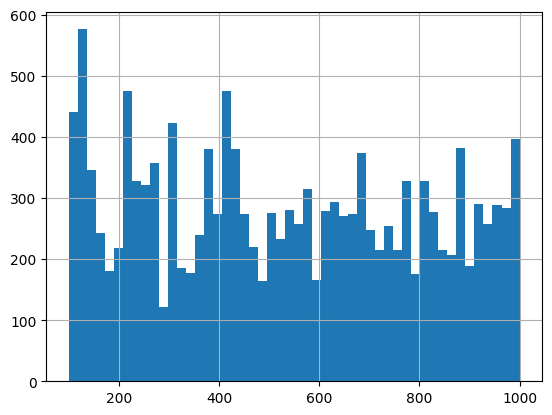

In [ ]:
df_train[df_train['garage'] >= 50]['garage'].hist(bins=50)

## hasStorageRoom

<Axes: >

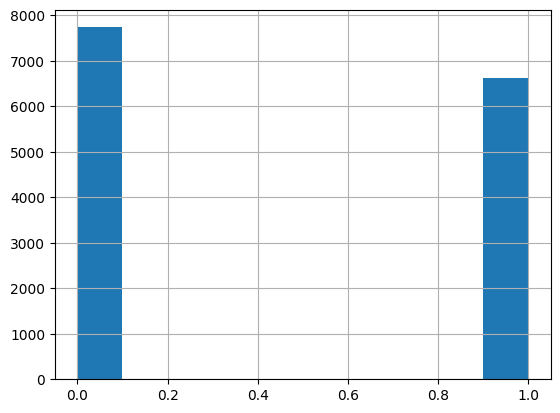

In [ ]:
df_train.hasStorageRoom.hist()

<Axes: xlabel='hasStorageRoom'>

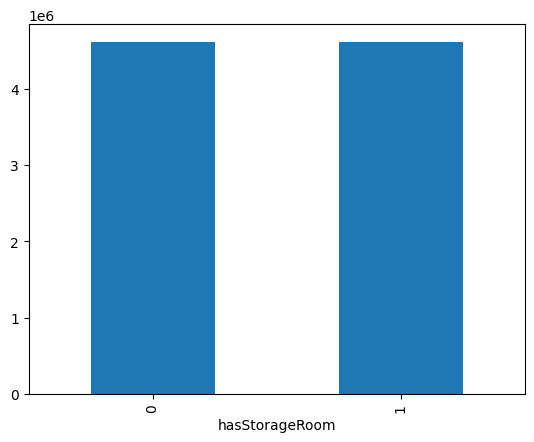

In [ ]:
df_train \
    .groupby('hasStorageRoom')['price'] \
    .aggregate('mean') \
    .plot(kind='bar')

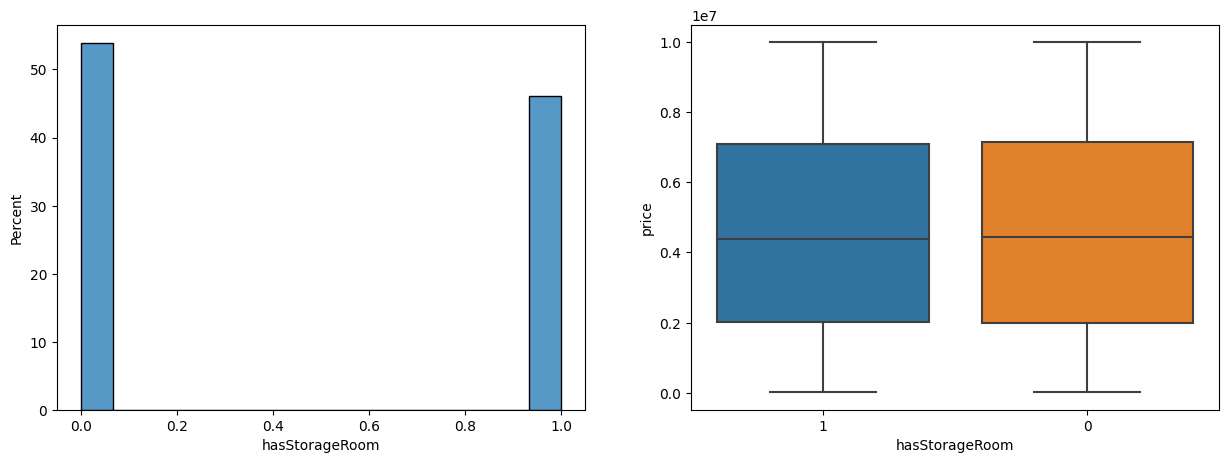

In [ ]:
from sklearn_utils import boxplot_regression

boxplot_regression(df_train, 'hasStorageRoom', 'price')

## hasGuestRoom

<Axes: >

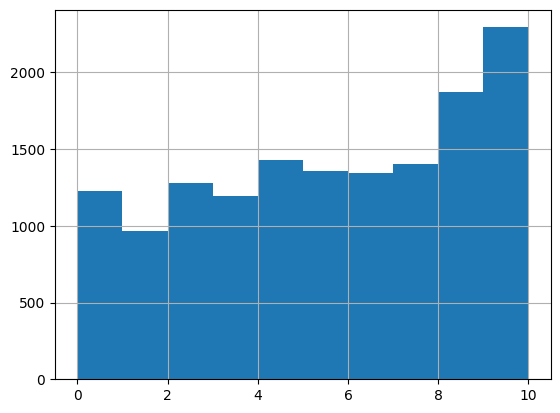

In [ ]:
df_train.hasGuestRoom.hist()

In [ ]:
df_train.hasGuestRoom.unique()

array([10,  5,  8,  9,  1,  3,  2,  4,  6,  0,  7])

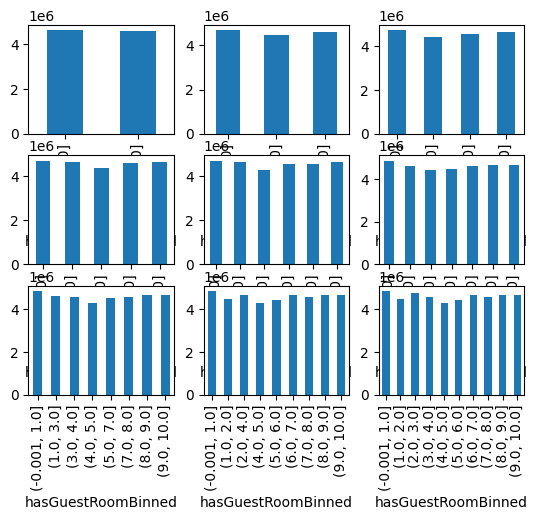

In [ ]:
n_bins = np.arange(3, 12)
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, n in enumerate(n_bins):

    df_train['hasGuestRoomBinned'] = pd.qcut(
        df_train['hasGuestRoom'],
        np.linspace(0, 1, n, endpoint=True)
    )

    df_train.groupby('hasGuestRoomBinned')['price'] \
        .aggregate('mean') \
        .plot(kind='bar', ax=ax[i])

## price

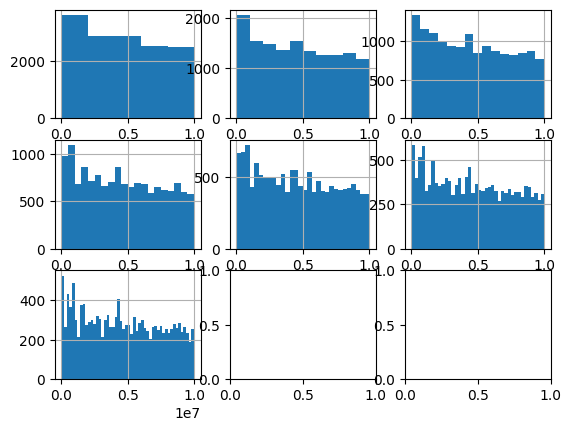

In [ ]:
_, ax = plt.subplots(3, 3)
ax = ax.flatten()

for i, b in enumerate([5, 10, 15, 20, 30, 40, 50]):
    df_train.price.hist(bins=b, ax=ax[i])

<Axes: >

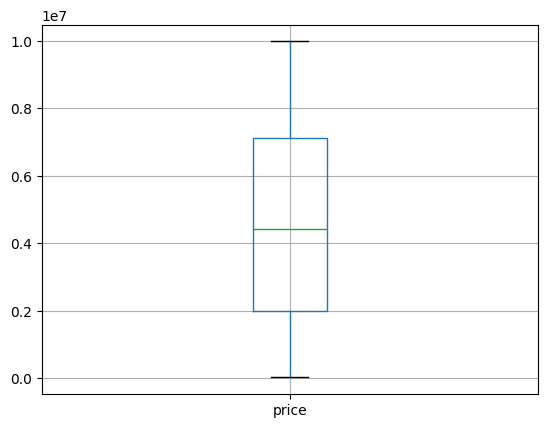

In [ ]:
df_train[['price']].boxplot()

# Feature engineering possibilities

## boxesChecked

<Axes: xlabel='hasYard,hasPool,hasStormProtector,hasStorageRoom,isNewBuilt'>

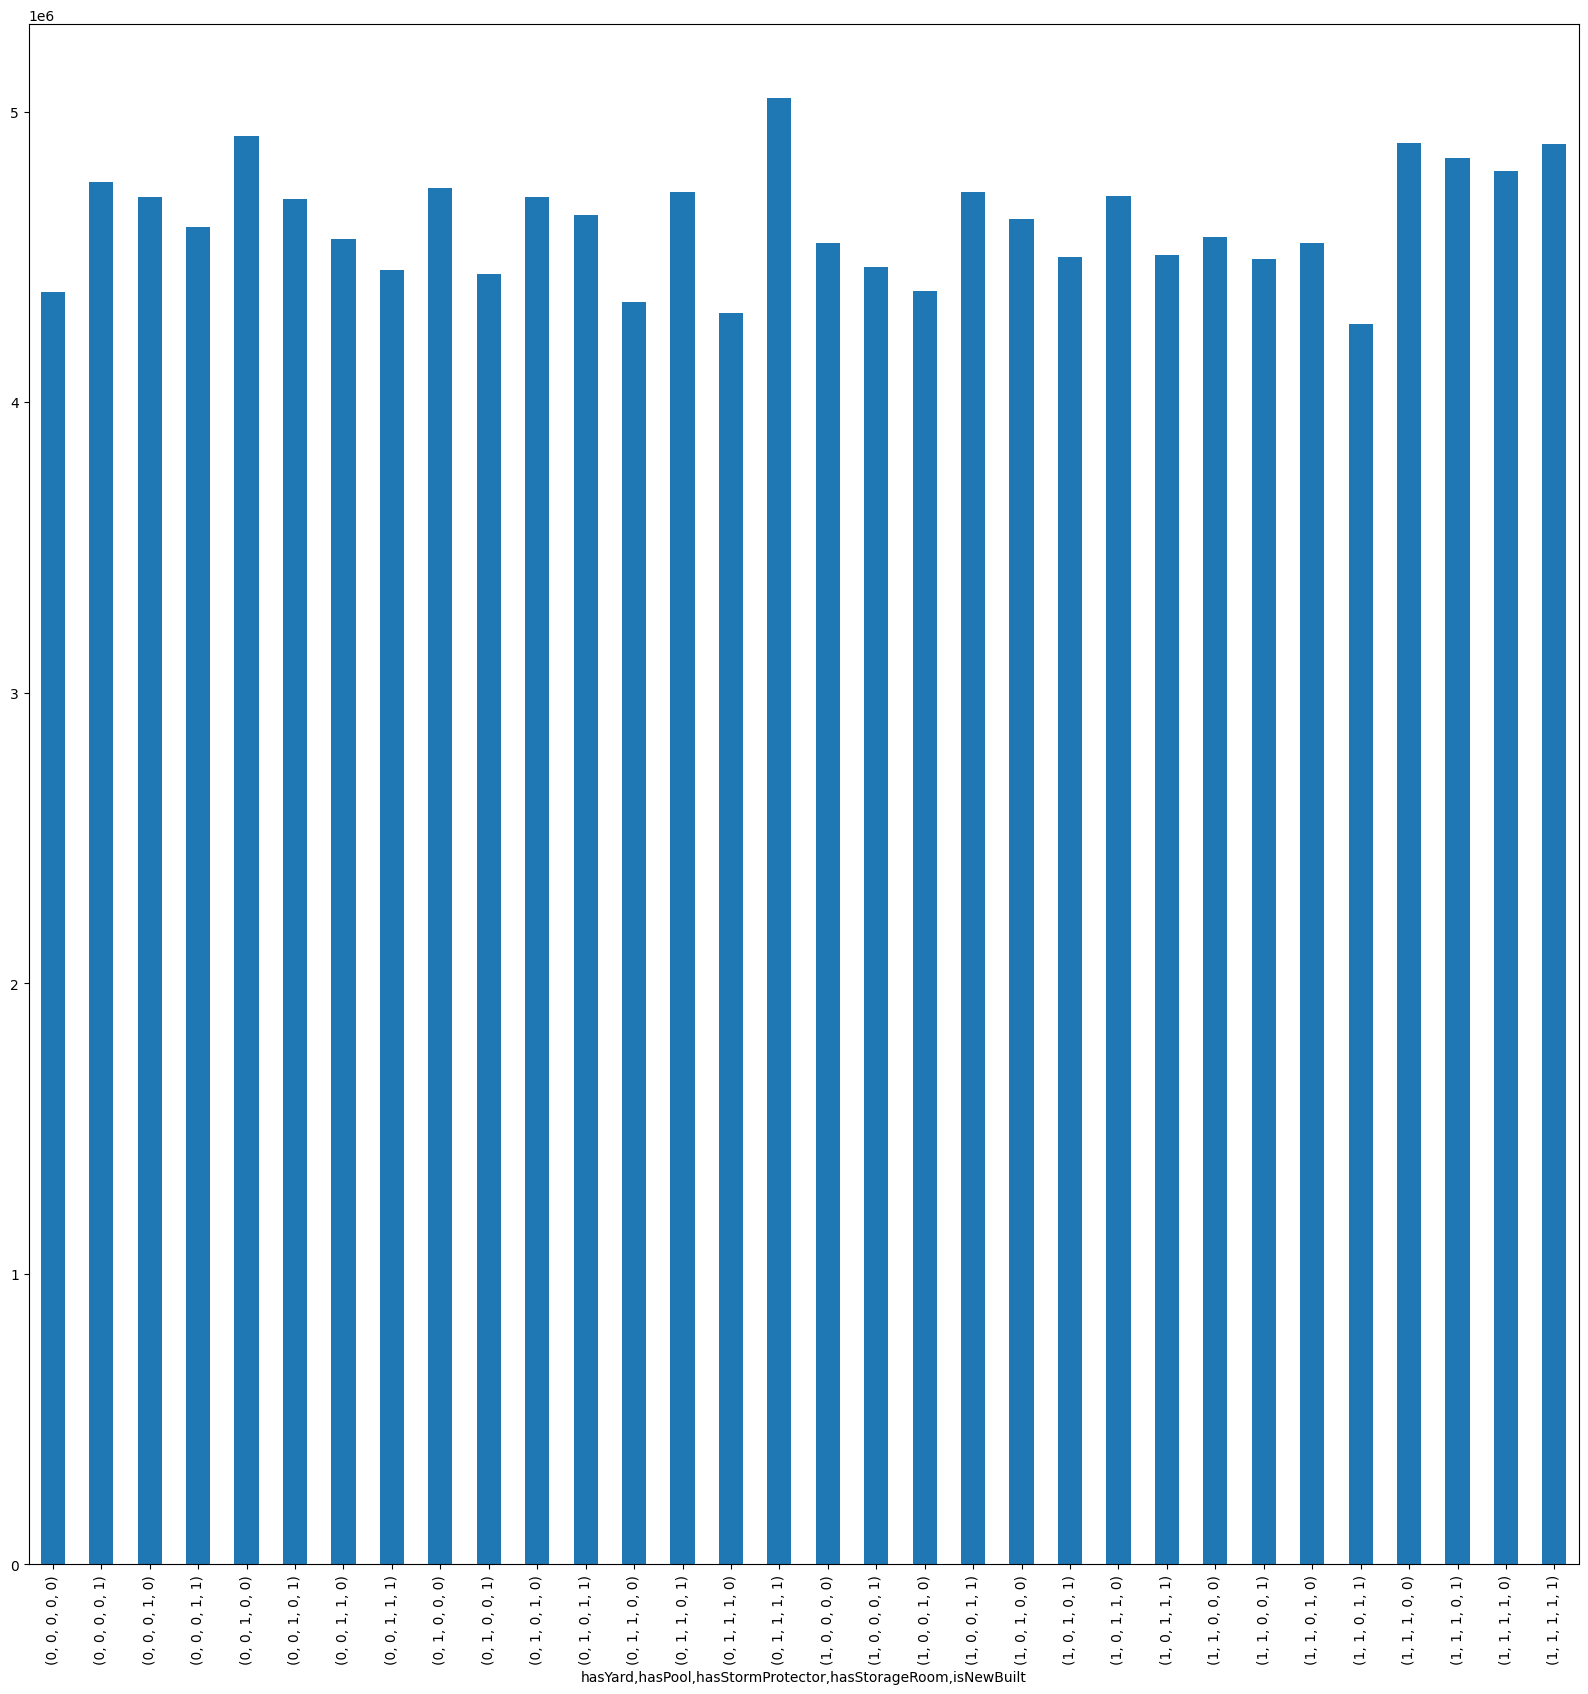

In [ ]:
df_train \
    .groupby(
        [
            'hasYard',
            'hasPool',
            'hasStormProtector',
            'hasStorageRoom',
            'isNewBuilt'
            # 'hasGuestRoom'
        ]
    )['price'] \
    .aggregate('mean') \
    .plot(kind='bar', figsize=(20, 20))

In [ ]:
df_train['boxesChecked'] = \
    df_train['hasYard'] + \
    df_train['hasPool'] + \
    df_train['hasStormProtector'] + \
    df_train['hasStorageRoom'] + \
    df_train['isNewBuilt'] + \
    (df_train['hasGuestRoom'] > 0)


<Axes: xlabel='boxesChecked'>

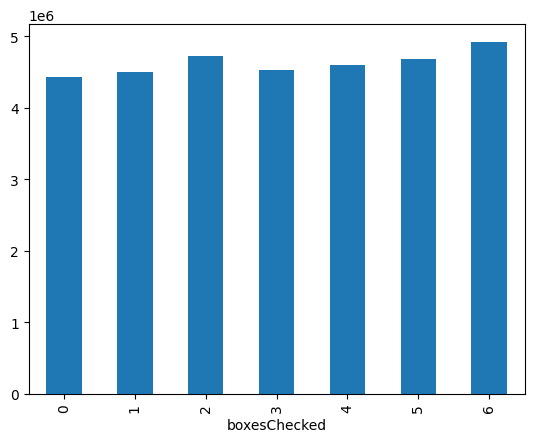

In [ ]:
df_train.groupby('boxesChecked')['price'].aggregate('mean').plot(kind='bar')

In [ ]:
df_train.hasGuestRoom.unique()

array([10,  5,  8,  9,  1,  3,  2,  4,  6,  0,  7])

## squareMetersPerRoom

In [21]:
df_train['squareMetersPerRoom'] = df_train['squareMeters'] / df_train['numberOfRooms']

<Axes: >

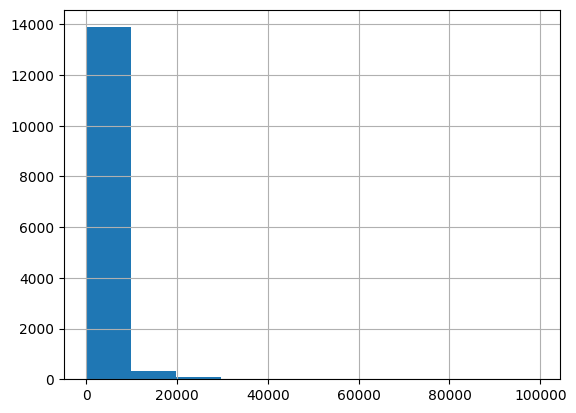

In [22]:
df_train['squareMetersPerRoom'].hist()

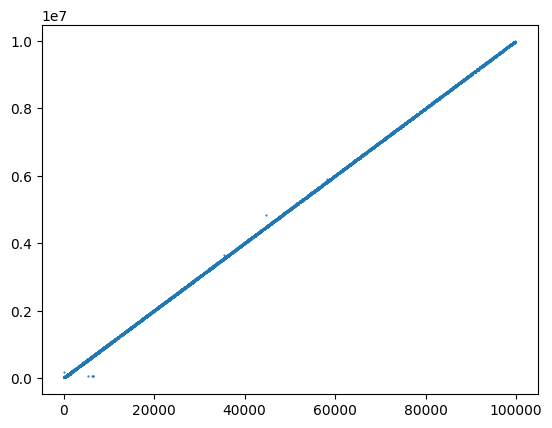

In [23]:
plt.scatter(
    y=df_train['price'],
    x=df_train['squareMeters'],
    s=0.3
)

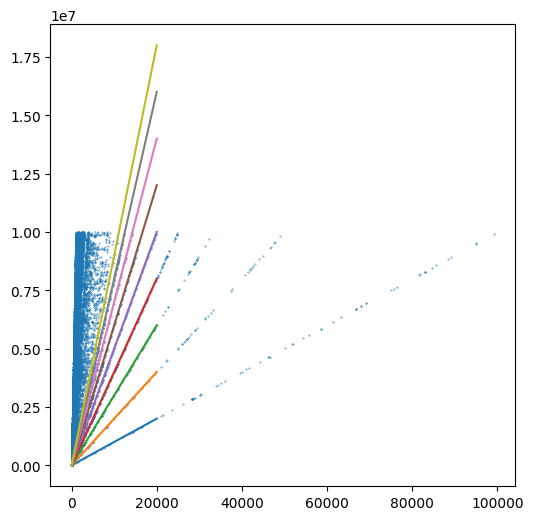

In [38]:
# sns.pairplot(
#     df_train[['squareMetersPerRoom', 'price']]
# )

_, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    y=df_train['price'],
    x=df_train['squareMetersPerRoom'],
    s=0.1
)


xs = np.arange(0, 20000)

for c in range(100, 1000, 100):
    ax.plot(
        xs,
        [c*x for x in xs]
    )


(384, 18)
(394, 18)
(449, 18)
(600, 18)
(562, 18)
(615, 18)
(538, 18)


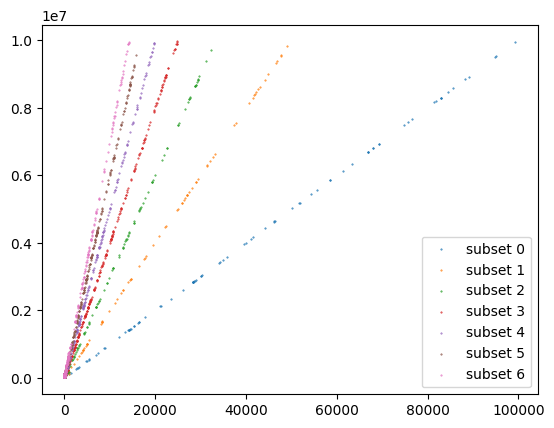

In [58]:
EPSILON = 100000
COEFS = range(100, 800, 100)
subsets = []

_, ax = plt.subplots()

for i, coef in enumerate(COEFS):

    subset = df_train.loc[
        (df_train['price'] <= df_train['squareMetersPerRoom'] * coef + EPSILON) &
        (df_train['price'] >= df_train['squareMetersPerRoom'] * coef - EPSILON)
    ]

    print(subset.shape)
    subsets.append(subset)

    ax.scatter(
        y=subset['price'],
        x=subset['squareMetersPerRoom'],
        s=0.2,
        label=f'subset {i}'
    )

ax.legend()

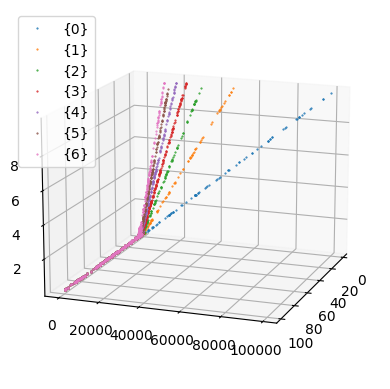

In [140]:
ax = plt.axes(projection='3d')

for i, subset in enumerate(subsets[:]):

# Data for a three-dimensional line
    zline = subset['price'] # np.linspace(0, 15, 1000)
    xline = subset['numberOfRooms']  # np.sin(zline)
    yline = subset['squareMetersPerRoom']  # np.cos(zline)
    ax.plot3D(xline, yline, zline, linewidth=0, marker='o', label={i}, markersize=0.5)
    # ax.scatter3D(xline, yline, zline, c=zline)

ax.legend()
ax.view_init(elev=15, azim=20)
# Data for three-dimensional scattered points
# zdata = 15 * np.random.random(100)
# xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
# ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

<Axes: xlabel='squareMetersPerRoom', ylabel='price'>

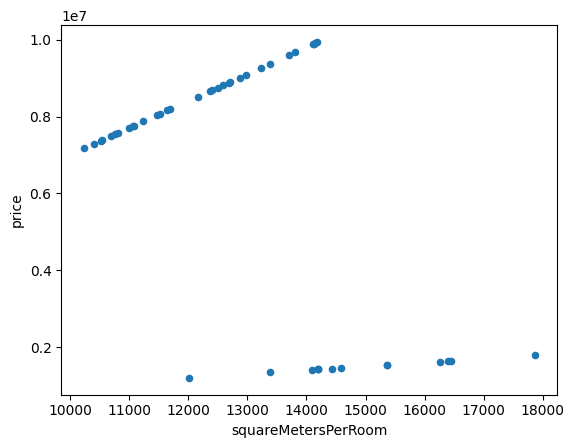

In [94]:
_, ax = plt.subplots()

subsets[0].loc[subsets[0]['squareMetersPerRoom'].between(10000, 21000)].plot(
    y='price',
    x='squareMetersPerRoom',
    kind='scatter',
    ax=ax
)

subsets[6].loc[subsets[6]['squareMetersPerRoom'].between(10000, 21000)].plot(
    y='price',
    x='squareMetersPerRoom',
    kind='scatter',
    ax=ax
)

In [98]:
subsets[6].loc[subsets[6]['squareMetersPerRoom'].between(10000, 21000)].head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
17493         86558              7        1        1      19      5952   
9656          99301              7        0        1      85     78921   
7143          93650              7        0        1      41     57287   
6224          90072              7        0        0      59      6252   
13488         75354              7        0        1      38     95955   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
17493              7             10  2007           0                  1   
9656               8              5  2014           1                  1   
7143               1              3  2005           0                  0   
6224               4              8  2007           1                  1   
13488              5              7  2019           1                  0   

       basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
id                                                                        
17493      3026    996     575               0             1  8658306.7   
9656       6406   7473     782               1             9  9941220.4   
7143       6657   3594     225               0             7  9375981.5   
6224       8370   9006     777               0             9  9008547.7   
13488       168   8157     874               0             7  7546076.9   

       squareMetersPerRoom  
id                          
17493         12365.428571  
9656          14185.857143  
7143          13378.571429  
6224          12867.428571  
13488         10764.857143

In [99]:
subsets[0].loc[subsets[0]['squareMetersPerRoom'].between(10000, 21000)].head()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
3218          14436              1        0        1      12     45055   
1301          13389              1        1        0      83     66489   
8531          16444              1        0        1       2     61599   
11042         14194              1        1        1      73      1906   
15984         15355              1        1        1       1     96283   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
3218               2              9  2000           1                  0   
1301               4              9  2015           1                  1   
8531               2              1  1995           0                  1   
11042              9              7  2003           1                  0   
15984              4              5  2000           1                  1   

       basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
id                                                                        
3218       9341   1449     711               1             9  1444902.2   
1301       4011   4291     140               1             4  1349726.5   
8531       3284   5318     604               0             6  1649094.5   
11042      4549   1368     755               1             6  1429956.3   
15984       730   8075     891               0             5  1544783.2   

       squareMetersPerRoom  
id                          
3218               14436.0  
1301               13389.0  
8531               16444.0  
11042              14194.0  
15984              15355.0

In [62]:
subsets[4].tail()

squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
id                                                                       
11943           656             81        1        1      12     90143   
13822         23754              5        0        0      69     64577   
20331         26090              5        1        0      42     43938   
11333           579             25        1        0      37      1839   
7858          26792              5        1        1      83     67387   

       cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
id                                                                         
11943              6              3  2016           0                  0   
13822              7              1  2017           0                  0   
20331              9              1  1995           0                  0   
11333              3              2  1994           1                  1   
7858               9              4  2003           1                  0   

       basement  attic  garage  hasStorageRoom  hasGuestRoom      price  \
id                                                                        
11943      3735   1777     260               1             4    68528.6   
13822      3294   6067     126               1             5  2379379.7   
20331      7518   9696     712               1             9  2613900.5   
11333      7057   5060     976               0             7    63718.4   
7858       3145   9398     327               0             8  2684819.3   

       squareMetersPerRoom  
id                          
11943             8.098765  
13822          4750.800000  
20331          5218.000000  
11333            23.160000  
7858           5358.400000

Visualizing datasets distributions
(6, 3) <class 'numpy.ndarray'>


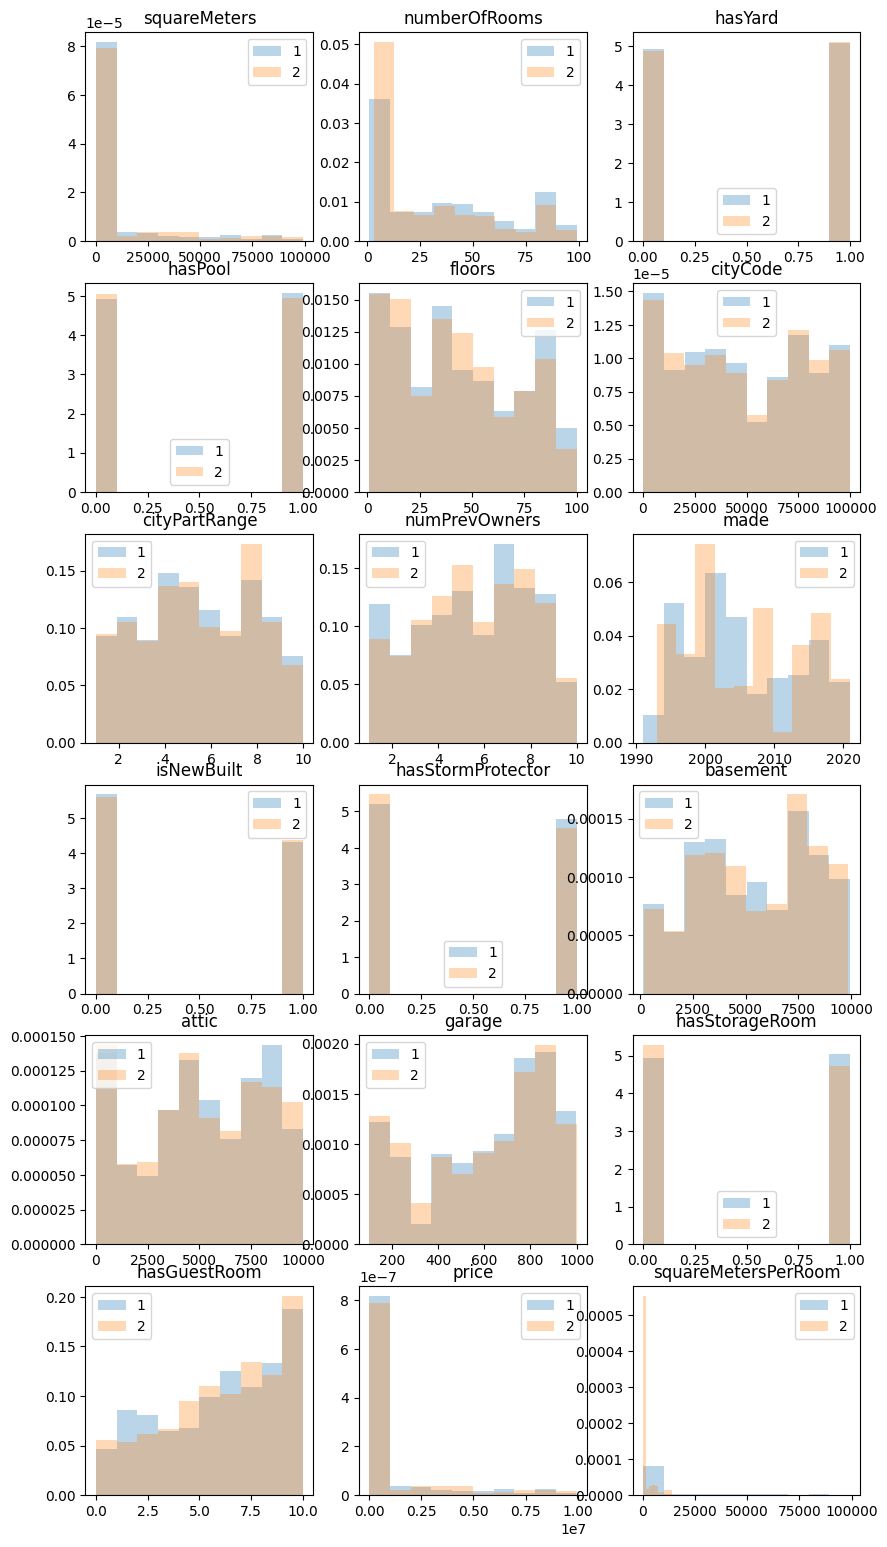

In [81]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        '1': subsets[0],
        '2': subsets[6],
    },
    columns=subsets[0].columns,

)

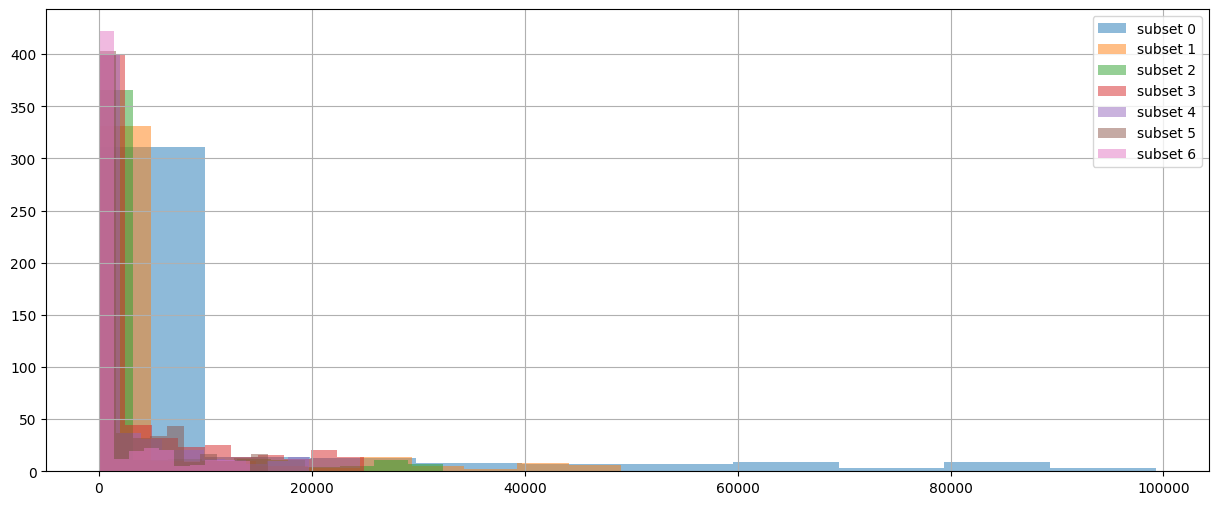

In [97]:
_, ax = plt.subplots(figsize=(15, 6))

for i, s in enumerate(subsets):
    s['squareMetersPerRoom'].hist(ax=ax, label=f'subset {i}', alpha=0.5)
ax.legend()

# Conclusions

- Clean outliers (anomalies) before splitting the datasets
- squareMeters is in perfect correlation with target
- add boxesChecked feature
- add the binned floors feature
- add the cityCodeBinned feature
- add the madeBinned feature
- There are several groups in the data, based on 'squareMetersPerRoom' -> for the same feature value, different prices will be predicted. I don't yet understand why